# 1. Setup and Installation
In this section we install and import relevant libraries.

We also set reproducibility parameters (seeds)

In [1]:
# Imports

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.models as models

# sklearn
from sklearn.manifold import TSNE

# Huggingface
from datasets import load_dataset

# Utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import os
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pickle
from datetime import datetime
from glob import glob
import math
from itertools import combinations

In [2]:
# Seed for randomness reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
def setup_experiment(base_dir="experiments"):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    exp_dir = os.path.join(base_dir, timestamp)
    dirs = {
        "root": exp_dir,
        "models": os.path.join(exp_dir, "models"),
        "histories": os.path.join(exp_dir, "histories"),
        "figures": os.path.join(exp_dir, "figures"),
    }
    for d in dirs.values():
        os.makedirs(d, exist_ok=True)
    print(f"✅ Experiment directory created at: {exp_dir}")
    return dirs

In [4]:
def exp_path(subdir, filename):
    return os.path.join(EXP_DIRS[subdir], filename)

In [23]:
# New experiment
# EXP_DIR = setup_experiment()


# Old experiment
EXPERIMENT_ROOT = "experiments/20251013_204845"

EXP_DIRS = {
    "root": EXPERIMENT_ROOT,
    "models": os.path.join(EXPERIMENT_ROOT, "models"),
    "histories": os.path.join(EXPERIMENT_ROOT, "histories"),
    "figures": os.path.join(EXPERIMENT_ROOT, "figures")
}

# 2. Dataset Preparation
In this section, we prepare a global configuration enum that will include some training hyperparameters such as learning rate, batch size, number of epochs etc.

We also download and transform our data domains according to the model backbone we will be using.

Further, we create dataloaders for each domain.

In [6]:
# Dataset configuration
class Config:
    DATASET_NAME = "PACS"  # "PACS" or "OfficeHome", "DomainNet"
    SOURCE_DOMAINS = ["art_painting", "cartoon", "photo"]
    TARGET_DOMAIN = "sketch"
    NUM_CLASSES = 7
    BATCH_SIZE = 32
    IMG_SIZE = 224
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
config = Config()

In [7]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # <-- ImageNet normalization
])

test_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # <-- ImageNet normalization
])

In [8]:
# PACS Dataset from Huggingface
dataset = load_dataset('flwrlabs/pacs')

# First, let's explore the dataset structure
print("Dataset structure:", dataset)
print("\nAvailable splits:", list(dataset.keys()))

# Let's see what a sample looks like
sample = dataset['train'][0]
print("\nSample keys:", sample.keys())
print("Sample domain:", sample['domain'])
print("Sample label:", sample['label'])
print("Image type:", type(sample['image']))

# Check all available domains
all_domains = set()
for split in dataset.keys():
    domains = dataset[split].unique('domain')
    all_domains.update(domains)
print("\nAll available domains:", all_domains)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'domain', 'label'],
        num_rows: 9991
    })
})

Available splits: ['train']

Sample keys: dict_keys(['image', 'domain', 'label'])
Sample domain: art_painting
Sample label: 0
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>

All available domains: {'sketch', 'art_painting', 'cartoon', 'photo'}


In [9]:
class PACSDataset(Dataset):
    def __init__(self, hf_subset, transform=None):
        """
        Args:
            hf_subset: A subset of the Hugging Face PACS dataset (already filtered for domain + split)
            transform: Torchvision transform to apply
        """
        self.data = hf_subset
        self.transform = transform
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        label = item['label']

        # Handle both integer or string labels
        if isinstance(label, str):
            label = self.class_to_idx[label]
        elif isinstance(label, int):
            # sanity check to ensure label is within 0–6
            assert 0 <= label < len(self.classes), f"Unexpected label value: {label}"

        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
def create_datasets(hf_dataset, test_size=0.2, seed=42):
    """
    Creates train/test splits for PACS domains manually using sklearn's train_test_split.
    """

    source_train_datasets = {} # {domain: data}
    all_source_train_subsets = [] # [data]
    source_val_datasets = {} # {domain: data}

    # --- Source Domains ---
    for domain in config.SOURCE_DOMAINS:
        # Filter all samples for this domain
        domain_data = hf_dataset['train'].filter(lambda x: x['domain'] == domain)
        indices = list(range(len(domain_data)))

        train_idx, val_idx = train_test_split(indices, test_size=test_size, random_state=seed, shuffle=True)

        train_subset = domain_data.select(train_idx)
        val_subset = domain_data.select(val_idx)

        # Wrap in custom Dataset
        train_ds = PACSDataset(train_subset, transform=train_transform)
        val_ds = PACSDataset(val_subset, transform=test_transform)

        source_train_datasets[domain] = train_ds
        source_val_datasets[domain] = val_ds
        all_source_train_subsets.append(train_ds)

    # Combine all source domains for ERM
    combined_source_dataset = ConcatDataset(all_source_train_subsets)

    # --- Target Domain (unseen) ---
    target_data = hf_dataset['train'].filter(lambda x: x['domain'] == config.TARGET_DOMAIN)
    target_dataset = PACSDataset(target_data, transform=test_transform)

    return source_train_datasets, source_val_datasets, combined_source_dataset, target_dataset

In [11]:
source_train_datasets, source_val_datasets, combined_source_dataset, target_dataset = create_datasets(dataset)

# Train loaders
source_loaders = {
    domain: DataLoader(ds, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
    for domain, ds in source_train_datasets.items()
}

combined_source_loader = DataLoader(
    combined_source_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2
)

# Validation loaders
source_val_loaders = {
    domain: DataLoader(ds, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
    for domain, ds in source_val_datasets.items()
}

# Target loader (OOD)
target_loader = DataLoader(
    target_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2
)

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

In [12]:
print("Source domains:", config.SOURCE_DOMAINS)
for d in config.SOURCE_DOMAINS:
    print(f"{d}: train={len(source_train_datasets[d])}, val={len(source_val_datasets[d])}")
print(f"Target domain ({config.TARGET_DOMAIN}): {len(target_dataset)} samples")

batch = next(iter(combined_source_loader))
print("Batch shape:", batch[0].shape)

Source domains: ['art_painting', 'cartoon', 'photo']
art_painting: train=1638, val=410
cartoon: train=1875, val=469
photo: train=1336, val=334
Target domain (sketch): 3929 samples
Batch shape: torch.Size([32, 3, 224, 224])


In [13]:
def visualize_domain_samples(datasets_dict, num_samples=5, title_prefix=""):
    """
    Visualize random samples from each domain in the provided dataset dictionary.
    Args:
        datasets_dict: dict[str, Dataset]
        num_samples: number of samples per domain
        title_prefix: e.g. "Train" or "Validation"
    """
    for domain, ds in datasets_dict.items():
        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
        fig.suptitle(f"{title_prefix} Domain: {domain}", fontsize=14)

        indices = np.random.choice(len(ds), num_samples, replace=False)
        for i, idx in enumerate(indices):
            img, label = ds[idx]

            # Convert tensor back to displayable image
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                          np.array([0.485, 0.456, 0.406]), 0, 1)

            axes[i].imshow(img)
            axes[i].set_title(f"Label: {label}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

In [14]:
# visualize_domain_samples(source_train_datasets, title_prefix="Train")
# visualize_domain_samples(source_val_datasets, title_prefix="Validation")

In [15]:
# visualize_domain_samples({config.TARGET_DOMAIN: target_dataset}, title_prefix="Target")

# 3. Model Definition
Here we define a wrapper class for the model we will be using. This wrapper class will facilitate experiments by letting us extract features just before the classification layer for analysis and visualization

In [16]:
class DomainGeneralizationModel(nn.Module):
    def __init__(self, num_classes, method='erm', pretrained: bool = True):
        super().__init__()
        self.method = method
        if pretrained:
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # <-- unified pre-trained backbone
        else:
            self.backbone = models.resnet50()
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)
    
    def get_features(self, x):
        # Extract features before classification layer
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# 4. Experiments

In [26]:
class BaseTrainer:
    def __init__(self, model, optimizer, criterion, device, workdir=None):
        self.model = model
        self.method = self.model.method
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.workdir = workdir or EXP_DIRS["root"]
        os.makedirs(self.workdir, exist_ok=True)

    def compute_loss(self, outputs, labels, domain_name=None):
        """Default: plain ERM loss (override in subclass)."""
        return self.criterion(outputs, labels), None, None  # total, erm, penalty

    # -------------------------
    # Training
    # -------------------------
    def train_step_seq(self, dataloaders_dict):
        """
        Iterate sequentially over domain loaders (IRM, Group DRO, etc.)
        Collects ERM, Penalty, and Total loss stats for each domain.
        """
        self.model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        total_erm, total_penalty = 0, 0

        for domain, loader in dataloaders_dict.items():
            domain_correct, domain_samples = 0, 0
            pbar = tqdm(loader, desc=f"train_{domain}", leave=False)
            for imgs, labels in pbar:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(imgs)

                # compute_loss returns total_loss, erm_loss, penalty
                loss, erm, penalty = self.compute_loss(outputs, labels)
                loss.backward()
                self.optimizer.step()

                batch_n = labels.size(0)
                preds = outputs.argmax(1)
                batch_correct = (preds == labels).sum().item()

                total_loss += loss.item() * batch_n
                total_correct += batch_correct
                total_samples += batch_n
                if erm is not None:
                    total_erm += erm * batch_n
                if penalty is not None:
                    total_penalty += penalty * batch_n
                domain_correct += batch_correct
                domain_samples += batch_n

                pbar.set_postfix({
                    "loss": total_loss / total_samples,
                    "acc": f"{total_correct * 100 / total_samples:.2f}%",
                    "erm": erm if erm is not None else "-",
                    "penalty": penalty if penalty is not None else "-"
                })

        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        avg_erm = total_erm / total_samples if total_erm > 0 else None
        avg_penalty = total_penalty / total_samples if total_penalty > 0 else None

        return avg_loss, avg_acc, avg_erm, avg_penalty

    def train_step_combined(self, dataloader):
        """Train on one combined DataLoader (typical ERM)."""
        self.model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        pbar = tqdm(dataloader, desc="train_combined", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(imgs)
            loss, _, _ = self.compute_loss(outputs, labels)
            loss.backward()
            self.optimizer.step()

            batch_n = imgs.size(0)
            total_loss += loss.item() * batch_n
            preds = outputs.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_samples += batch_n

            pbar.set_postfix({
                "loss": total_loss / total_samples,
                "acc": f"{total_correct * 100 / total_samples:.2f}%"
            })

        return total_loss / total_samples, total_correct / total_samples, None, None

    # -------------------------
    # Evaluation
    # -------------------------
    @torch.no_grad()
    def evaluate(self, dataloader):
        self.model.eval()
        total_loss, total_correct, total_samples = 0, 0, 0
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            outputs = self.model(imgs)
            loss = self.criterion(outputs, labels).mean()
            total_loss += loss.item() * imgs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)
        return total_loss / total_samples, total_correct / total_samples

    def evaluate_per_domain(self, loaders_dict):
        """Return dict(domain -> accuracy)."""
        results = {}
        for domain, loader in loaders_dict.items():
            _, acc = self.evaluate(loader)
            results[domain] = acc
        return results

    # -------------------------
    # Checkpointing
    # -------------------------
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))

   # -------------------------
# Training orchestration
# -------------------------
    def fit(self,
        source_val_loaders,
        target_loader,
        save_name,
        combined_train_loader=None,
        dataloaders_dict=None,
        epochs=10,
        eval_every=1):
        history = {
            "train_loss": [],
            "train_acc": [],
            "train_erm": [],
            "train_penalty": [],
            "val_avg": [],
            "val_per_domain": [],
            "target_acc": [],
            "q_history": []
        }
    
        best_avg, best_model_path = -1.0, None
    
        for epoch in range(1, epochs + 1):
            # ----------------------------
            # 1. Train one epoch
            # ----------------------------
            erm_loss = penalty = None
            per_domain_losses = q = None
        
            if self.method in ["erm", "sam"]:
                train_loss, train_acc, _, _ = self.train_step_combined(combined_train_loader)
            elif self.method == "irm":
                train_loss, train_acc, erm_loss, penalty = self.train_step_seq(dataloaders_dict)
                history["train_erm"].append(erm_loss)
                history["train_penalty"].append(penalty)
            elif self.method == "gdro":
                train_loss, train_acc, per_domain_losses, q = self.train_step_seq(dataloaders_dict)
                history["q_history"].append(q)
        
            # ----------------------------
            # 2. Validation
            # ----------------------------
            val_per_domain = self.evaluate_per_domain(source_val_loaders)
            val_avg = np.mean(list(val_per_domain.values()))
        
            # record metrics
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_avg"].append(val_avg)
            history["val_per_domain"].append(val_per_domain)
        
            # ----------------------------
            # 3. Logging
            # ----------------------------
            print("=" * 80)
            print(f"[{self.method.upper()}] Epoch {epoch}/{epochs}")
            print(f"| train_loss = {train_loss:.4f} | train_acc = {train_acc*100:6.2f}% | val_avg = {val_avg*100:6.2f}%")
        
            if self.method == "irm":
                erm_str = f"{erm_loss:.6f}" if erm_loss is not None else "-"
                pen_str = f"{penalty:.6f}" if penalty is not None else "-"
                print(f"| train_erm  = {erm_str} | penalty = {pen_str} | λ = {self.irm_penalty_weight}")
        
            elif self.method == "gdro":
                print("| Per-domain losses and weights:")
                for dname, dloss, dq in zip(self.domains, np.round(per_domain_losses, 4), np.round(q, 4)):
                    print(f"|   {dname:<12} loss={dloss:<8.4f} q={dq:<8.4f}")
                worst_idx = int(np.argmax(per_domain_losses))
                print(f"| → Worst domain: {self.domains[worst_idx]} "
                      f"(loss={per_domain_losses[worst_idx]:.4f}, q={q[worst_idx]:.4f})")
        
            # ----------------------------
            # 4. Save best model
            # ----------------------------
            if val_avg > best_avg:
                best_avg = val_avg
                best_model_path = exp_path("models", f"best_{self.method}.pt")
                self.save_model(best_model_path)
                print(f"[Checkpoint] saved new best model: {best_model_path}")

        
        print("=" * 80)
        # Final model snapshot
        final_model_path = exp_path("models", f"final_{self.method}.pt")
        self.save_model(final_model_path)
        print(f"[Checkpoint] saved final model: {final_model_path}")
        # ----------------------------
        # 5. Load best and test
        # ----------------------------
        if best_model_path:
            self.load_model(best_model_path)
    
        t_loss, t_acc = self.evaluate(target_loader)
        history["target_acc"].append(t_acc)

        # Save final history
        final_hist_path = exp_path("histories", f"final_{self.method}_history.pkl")
        with open(final_hist_path, "wb") as f:
            pickle.dump(history, f)
    
        print(f"\n[{self.method.upper()}] Best avg-source-val={best_avg*100:.4f}% "
              f"| Target acc={t_acc*100:.4f}%")

        return history, val_per_domain, t_acc

## 4.1 Empirical Risk Minimization
This experiment serves as a baseline because we take no dedicated steps to adapt our model to unseen domain.

A simple training routine is implemented: train on k-1 domains and evaluate on last domain

In [18]:
class ERMTrainer(BaseTrainer):
    def __init__(self, model, optimizer, criterion, device, workdir=None):
        super().__init__(model, optimizer, criterion, device, workdir)

In [19]:
# # instantiate model, optimizer, criterion (re-use your DomainGeneralizationModel)
# erm_model = DomainGeneralizationModel(num_classes=config.NUM_CLASSES).to(config.DEVICE)
# optimizer = optim.Adam(erm_model.parameters(), lr=config.LEARNING_RATE)
# criterion = nn.CrossEntropyLoss()

# erm_trainer = ERMTrainer(erm_model, optimizer, criterion, config.DEVICE)

# # quick smoke test: 3 epochs; increase later
# erm_history, erm_val_per_domain, erm_target_acc = erm_trainer.fit(
#     combined_train_loader=combined_source_loader,
#     source_val_loaders=source_val_loaders,
#     target_loader=target_loader,
#     epochs=5,
#     save_name="best_erm.pt"
# )

# print("[ERM] Per-domain validation acc:", erm_val_per_domain)
# print("[ERM] Target acc:", erm_target_acc)

## 4.2 Invariant Risk Minimization
This is a first attempt to generalize to an unseen domain using IRMv1 where we try to force the feature extractor to produce latents that minimize risk for a common classificaiton head across all domains

In [27]:
class IRMTrainer(BaseTrainer):
    def __init__(self, model, optimizer, criterion, device, irm_penalty_weight=1.0, workdir=None):
        super().__init__(model, optimizer, criterion, device, workdir)
        self.irm_penalty_weight = irm_penalty_weight

        # dummy scalar classifier weight (not optimized)
        self.dummy_w = torch.nn.Parameter(torch.tensor([1.0], device=device))

    def compute_irm_penalty(self, losses):
        # Taken directly from the IRM paper
        g1 = grad ( losses [0::2]. mean () , self.dummy_w , create_graph = True )[0]
        g2 = grad ( losses [1::2]. mean () , self.dummy_w , create_graph = True )[0]
        return ( g1 * g2 ). sum ()
    
    def compute_loss(self, outputs, labels, domain_name=None):
        per_sample_losses = self.criterion(outputs * self.dummy_w, labels)
        penalty = self.compute_irm_penalty(per_sample_losses)
        erm_loss = per_sample_losses.mean()

        return erm_loss + self.irm_penalty_weight * (penalty / labels.size(0)), erm_loss.item(), penalty.item()

In [ ]:
def evaluate_irm_lambda_sweep(
    lambdas,
    model_fn,
    optimizer_fn,
    criterion,
    dataloaders_dict,
    source_val_loaders,
    target_loader,
    device,
    epochs=5,
    workdir=None,
):
    """
    Evaluate IRM performance for different penalty weights (λ).
    Trains a new model for each λ, saves best checkpoints, and reports target accuracy.

    Args:
        lambdas (list): list of λ (penalty weights) to test.
        model_fn: function that returns a fresh model instance, e.g. lambda: DomainGeneralizationModel(...).
        optimizer_fn: function that takes a model and returns an optimizer.
        criterion: loss function (should have reduction='none' for IRM).
        dataloaders_dict: dict of domain -> DataLoader (source domains).
        source_val_loaders: dict of domain -> DataLoader for validation.
        target_loader: DataLoader for unseen target domain.
        device: device string.
        epochs (int): training epochs per λ.
        workdir (str): experiment directory root.
    """
    results = []

    print("=" * 80)
    print("[IRM λ-SWEEP] Starting IRM experiments for different penalty weights")
    print("λ values:", lambdas)
    print("=" * 80)

    for lam in lambdas:
        print(f"\n--- Training IRM with λ = {lam} ---")

        # fresh model + optimizer for each λ
        irm_model = model_fn().to(device)
        optimizer = optimizer_fn(irm_model)

        irm_trainer = IRMTrainer(
            irm_model,
            optimizer,
            criterion,
            device=device,
            irm_penalty_weight=lam,
            workdir=workdir,
        )

        # run training
        irm_history, irm_val_per_domain, irm_target_acc = irm_trainer.fit(
            dataloaders_dict=dataloaders_dict,
            source_val_loaders=source_val_loaders,
            target_loader=target_loader,
            epochs=epochs,
            save_name=f"irm_lambda{lam}.pt",
        )

        # record results
        avg_val_acc = np.mean(list(irm_val_per_domain.values()))
        results.append({
            "lambda": lam,
            "val_avg": avg_val_acc,
            "target_acc": irm_target_acc,
            "history": irm_history,
        })

        print(f"[IRM λ={lam}] Avg Source Val = {avg_val_acc*100:.2f}% | Target = {irm_target_acc*100:.2f}%")

        # save history pickle for this λ
        hist_path = exp_path("histories", f"irm_lambda{lam}_history.pkl")
        with open(hist_path, "wb") as f:
            pickle.dump(irm_history, f)
        print(f"[Saved] History → {hist_path}")

    # summarize results
    print("\n========== IRM λ Sweep Summary ==========")
    for r in results:
        print(f"λ={r['lambda']:<6} | Val Avg={r['val_avg']*100:6.2f}% | Target={r['target_acc']*100:6.2f}%")

    return results

In [33]:
def plot_irm_lambda_sweep(results):
    # plot λ vs accuracy
    plt.figure(figsize=(6, 4))
    plt.plot([r["lambda"] for r in results],
             [r["target_acc"] * 100 for r in results],
             marker="o", label="Target Accuracy")
    plt.plot([r["lambda"] for r in results],
             [r["val_avg"] * 100 for r in results],
             marker="s", linestyle="--", label="Avg Source Val")
    plt.xscale("log")
    plt.xlabel("IRM Penalty Weight (λ)")
    plt.ylabel("Accuracy (%)")
    plt.title("IRM λ Sensitivity – Source vs Target Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    save_fig(plt.gcf(), "irm_lambda_sweep.png")
    plt.show()

In [21]:
# # instantiate model, optimizer, criterion (re-use your DomainGeneralizationModel)
# irm_model = DomainGeneralizationModel(num_classes=config.NUM_CLASSES, method='irm').to(config.DEVICE)
# optimizer = optim.Adam(irm_model.parameters(), lr=config.LEARNING_RATE)
# criterion = nn.CrossEntropyLoss(reduction='none')
# ƛ = 10
# irm_trainer = IRMTrainer(irm_model, optimizer, criterion, irm_penalty_weight=ƛ, device=config.DEVICE)

# # quick smoke test: 3 epochs; increase later
# irm_history, irm_val_per_domain, irm_target_acc = irm_trainer.fit(
#     dataloaders_dict=source_loaders,
#     source_val_loaders=source_val_loaders,
#     target_loader=target_loader,
#     epochs=5,
#     save_name="best_irm.pt"
# )

# print("[IRM] Per-domain validation acc:", irm_val_per_domain)
# print("[IRM] IRM Penalty Weight ƛ =", ƛ)
# print("[IRM] Target acc:", irm_target_acc)

[IRM λ-SWEEP] Starting IRM experiments for different penalty weights
λ values: [1, 10, 100]

--- Training IRM with λ = 1 ---


[IRM] Epoch 1/5
| train_loss = 0.5807 | train_acc =  84.97% | val_avg =  87.89%
| train_erm  = 0.578963 | penalty = 0.055889 | λ = 1
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt


[IRM] Epoch 2/5
| train_loss = 0.0963 | train_acc =  97.30% | val_avg =  92.32%
| train_erm  = 0.096204 | penalty = 0.003697 | λ = 1
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt


[IRM] Epoch 3/5
| train_loss = 0.0483 | train_acc =  98.58% | val_avg =  92.15%
| train_erm  = 0.048285 | penalty = 0.002359 | λ = 1


[IRM] Epoch 4/5
| train_loss = 0.0301 | train_acc =  99.07% | val_avg =  88.88%
| train_erm  = 0.030061 | penalty = 0.000463 | λ = 1


[IRM] Epoch 5/5
| train_loss = 0.0271 | train_acc =  99.32% | val_avg =  91.80%
| train_erm  = 0.027114 | penalty = 0.000929 | λ = 1
[Checkpoint] saved final model: experiments/20251013_204845/models/final_irm.pt

[IRM] Best avg-source-val=92.3161% | Target acc=66.9127%
[IRM λ=1] Avg Source Val = 91.80% | Target = 66.91%
[Saved] History → experiments/20251013_204845/histories/irm_lambda1_history.pkl

--- Training IRM with λ = 10 ---


[IRM] Epoch 1/5
| train_loss = 0.6081 | train_acc =  83.83% | val_avg =  89.63%
| train_erm  = 0.593425 | penalty = 0.046655 | λ = 10
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt


[IRM] Epoch 2/5
| train_loss = 0.0965 | train_acc =  97.15% | val_avg =  92.25%
| train_erm  = 0.095466 | penalty = 0.003076 | λ = 10
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt


[IRM] Epoch 3/5
| train_loss = 0.0338 | train_acc =  99.20% | val_avg =  89.20%
| train_erm  = 0.033382 | penalty = 0.001212 | λ = 10


[IRM] Epoch 4/5
| train_loss = 0.0284 | train_acc =  99.18% | val_avg =  88.43%
| train_erm  = 0.028134 | penalty = 0.000832 | λ = 10


[IRM] Epoch 5/5
| train_loss = 0.0374 | train_acc =  98.89% | val_avg =  92.35%
| train_erm  = 0.037137 | penalty = 0.001194 | λ = 10
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt
[Checkpoint] saved final model: experiments/20251013_204845/models/final_irm.pt

[IRM] Best avg-source-val=92.3527% | Target acc=65.8692%
[IRM λ=10] Avg Source Val = 92.35% | Target = 65.87%
[Saved] History → experiments/20251013_204845/histories/irm_lambda10_history.pkl

--- Training IRM with λ = 100 ---


[IRM] Epoch 1/5
| train_loss = 1.2481 | train_acc =  60.14% | val_avg =  69.33%
| train_erm  = 1.211105 | penalty = 0.011425 | λ = 100
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt


[IRM] Epoch 2/5
| train_loss = 0.5328 | train_acc =  84.90% | val_avg =  79.05%
| train_erm  = 0.491115 | penalty = 0.013289 | λ = 100
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt


[IRM] Epoch 3/5
| train_loss = 0.3379 | train_acc =  91.07% | val_avg =  77.17%
| train_erm  = 0.309569 | penalty = 0.009076 | λ = 100


[IRM] Epoch 4/5
| train_loss = 0.2573 | train_acc =  91.98% | val_avg =  82.49%
| train_erm  = 0.259179 | penalty = - | λ = 100
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt


[IRM] Epoch 5/5
| train_loss = 0.1765 | train_acc =  94.93% | val_avg =  88.43%
| train_erm  = 0.169835 | penalty = 0.002056 | λ = 100
[Checkpoint] saved new best model: experiments/20251013_204845/models/best_irm.pt
[Checkpoint] saved final model: experiments/20251013_204845/models/final_irm.pt

[IRM] Best avg-source-val=88.4279% | Target acc=69.5851%
[IRM λ=100] Avg Source Val = 88.43% | Target = 69.59%
[Saved] History → experiments/20251013_204845/histories/irm_lambda100_history.pkl

========== IRM λ Sweep Summary ==========
λ=1      | Val Avg= 91.80% | Target= 66.91%
λ=10     | Val Avg= 92.35% | Target= 65.87%
λ=100    | Val Avg= 88.43% | Target= 69.59%


NameError: name 'save_fig' is not defined

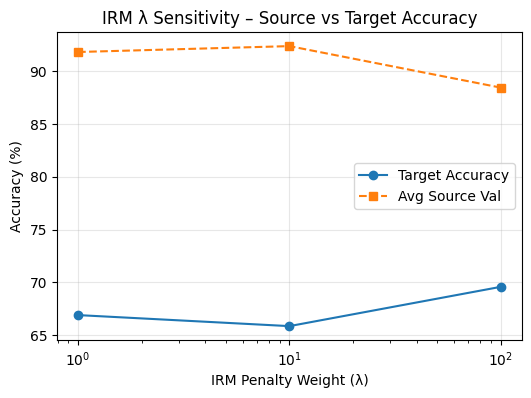

In [30]:
irm_lambda_results = evaluate_irm_lambda_sweep(
    lambdas=[1, 10, 100],
    model_fn=lambda: DomainGeneralizationModel(num_classes=config.NUM_CLASSES, method="irm"),
    optimizer_fn=lambda m: optim.Adam(m.parameters(), lr=config.LEARNING_RATE),
    criterion=nn.CrossEntropyLoss(reduction="none"),
    dataloaders_dict=source_loaders,
    source_val_loaders=source_val_loaders,
    target_loader=target_loader,
    device=config.DEVICE,
    epochs=5,
    workdir=EXP_DIRS["root"]
)

## 4.3 Group DRO
This experiment **(Distribution Robust Optimization)** minimizes loss on the worst performing domain, and thus we expect model to learn domain invariant features for better generalization

In [22]:
class GroupDROTrainer(BaseTrainer):
    def __init__(self, model, optimizer, criterion, device, domains, groupdro_eta=0.1, workdir=None):
        super().__init__(model, optimizer, criterion, device, workdir)
        self.domains = list(domains)
        self.num_domains = len(self.domains)
        self.groupdro_eta = groupdro_eta

        self.log_q = torch.zeros(self.num_domains, device=device)
        
    def train_step_seq(self, dataloaders_dict):
        """
        Synchronously sample one minibatch per domain each step.
        dataloaders_dict: ordered mapping domain->dataloader where order matches self.domains
        """
        self.model.train()
        device = self.device

        # create iterators for each domain loader
        iters = {d: iter(dataloaders_dict[d]) for d in self.domains}
        finished = False

        total_loss = 0.0
        total_samples = 0
        total_correct = 0
        total_domain_losses = torch.zeros(self.num_domains, device=device)
        total_domain_counts = torch.zeros(self.num_domains, device=device)

        # pbar = tqdm(total=100, desc="groupdro_epoch", leave=False)  # will update manually

        step = 0
        while True:
            # try to get a minibatch from each domain; if any domain exhausted, stop epoch
            minibatches = []
            try:
                for i, d in enumerate(self.domains):
                    imgs, labels = next(iters[d])
                    minibatches.append((imgs.to(device), labels.to(device)))
            except StopIteration:
                break  # end epoch once any loader is exhausted (alternatively you can re-init iterators)

            # compute per-domain losses (scalar)
            losses = torch.zeros(len(minibatches), device=device)
            accs = torch.zeros(len(minibatches), device=device)
            batch_sizes = torch.zeros(len(minibatches), device=device)
            for i, (imgs, labels) in enumerate(minibatches):
                outputs = self.model(imgs)
                # average loss for the minibatch
                losses[i], _, _ = self.compute_loss(outputs, labels)
                preds = outputs.argmax(dim=1)
                accs[i] = (preds == labels).float().mean()
                batch_sizes[i] = labels.size(0)

            # --- update q in log-space to avoid overflow ---
            # log_q <- log_q + eta * losses_detached
            losses_det = losses.detach()
            self.log_q = self.log_q + self.groupdro_eta * losses_det
            # normalize: q = softmax(log_q)
            q = torch.softmax(self.log_q, dim=0)

            # weighted loss
            weighted_loss = torch.dot(q, losses)

            # optimization step
            self.optimizer.zero_grad()
            weighted_loss.backward()
            # optional: gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            self.optimizer.step()

            # bookkeeping / logging
            step += 1
            bs_sum = batch_sizes.sum().item()
            total_loss += weighted_loss.item() * bs_sum
            total_samples += bs_sum
            # per-step weighted correct count (approx)
            # for overall training acc we compute an average over domain accuracies weighted by q
            total_correct += (accs * batch_sizes).sum().item()

            # accumulate domain stats for the epoch
            total_domain_losses += losses.detach() * batch_sizes
            total_domain_counts += batch_sizes

            # update progress bar (display q and worst-domain loss)
            worst_idx = torch.argmax(losses).item()
            worst_domain = self.domains[worst_idx]
            # pbar.set_description(f"GDO Epoch step {step} worst={worst_domain}")
            # pbar.set_postfix({
            #     "w_loss": weighted_loss.item(),
            #     "q": [float(x) for x in q.cpu().tolist()],
            #     "worst_loss": float(losses.max().item())
            # })
            if step % 25 == 0:
                print(f"[GDRO] Step {step:04d} | avg_loss={weighted_loss.item():.4f} | worst={self.domains[torch.argmax(losses)]}")


        #     pbar.update(1)
        # pbar.close()

        # epoch aggregates
        avg_loss = total_loss / max(1, total_samples)
        avg_acc = total_correct / max(1, total_samples)
        per_domain_avg_loss = (total_domain_losses / (total_domain_counts + 1e-12)).cpu().tolist()
        per_domain_acc = []  # compute per-domain acc by re-evaluating or track per-step accumulators (left as exercise)

        return avg_loss, avg_acc, per_domain_avg_loss, q.cpu().tolist()

In [23]:
# gdro_source_loaders = {d: source_loaders[d] for d in config.SOURCE_DOMAINS} # consistent ordering
# gdro_model = DomainGeneralizationModel(num_classes=config.NUM_CLASSES, method="gdro").to(config.DEVICE)
# optimizer = optim.Adam(gdro_model.parameters(), lr=config.LEARNING_RATE)
# criterion = nn.CrossEntropyLoss()
# gdro_trainer = GroupDROTrainer(gdro_model, optimizer, criterion, config.DEVICE, config.SOURCE_DOMAINS, groupdro_eta=0.1)

# gdro_history, gdro_val_per_domain, gdro_target_acc = gdro_trainer.fit(
#     dataloaders_dict=gdro_source_loaders,
#     source_val_loaders=source_val_loaders,
#     target_loader=target_loader,
#     epochs=5,
#     save_name="best_gdro.pt"
# )

# print("[Group DRO] Per-domain validation acc:", gdro_val_per_domain)
# print("[Group DRO] Target acc:", irm_target_acc)

## 4.4 Sharpness Aware Minimization
This approach aims to converge our model to a *"flat minima"* in the loss landscape, because ERM converges to sharp minima that are sensitive to perturbations and hence do not generalize effectively. A flat minima generalizes across domains **provided that the flatness is shared across domains for a specific learned model state**

In [24]:
# Adapted from https://github.com/davda54/sam/blob/main/sam.py
class SAM(optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [25]:
class SAMTrainer(BaseTrainer):
    def __init__(self, model, optimizer, criterion, device, rho=0.05, workdir=None):
        super().__init__(model, optimizer, criterion, device, workdir)
        self.rho = rho

    def train_step_combined(self, dataloader):
        """Two-step SAM training loop."""
        self.model.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        pbar = tqdm(dataloader, desc="train_sam", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(self.device), labels.to(self.device)

            # 1. forward-backward for perturbation
            outputs = self.model(imgs)
            loss, _, _ = self.compute_loss(outputs, labels)
            loss.backward()
            self.optimizer.first_step(zero_grad=True)

            # 2. forward-backward for SAM update
            self.criterion(self.model(imgs), labels).backward()
            self.optimizer.second_step(zero_grad=True)

            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            pbar.set_postfix(loss=total_loss / total_samples, acc=f"{100 * total_correct / total_samples:.2f}%")

        return total_loss / total_samples, total_correct / total_samples, None, None

In [26]:
# sam_model = DomainGeneralizationModel(num_classes=config.NUM_CLASSES, method="sam").to(config.DEVICE)
# optimizer = SAM(params=sam_model.parameters(),
#                 base_optimizer=optim.Adam,
#                 lr=config.LEARNING_RATE)
# criterion = nn.CrossEntropyLoss()
# sam_trainer = SAMTrainer(sam_model, optimizer, criterion, config.DEVICE)

# sam_history, sam_val_per_domain, sam_target_acc = sam_trainer.fit(
#     source_val_loaders=source_val_loaders,
#     combined_train_loader=combined_source_loader,
#     target_loader=target_loader,
#     epochs=5,
#     save_name="best_sam.pt"
# )

# print("[SAM] Per-domain validation acc:", sam_val_per_domain)
# print("[SAM] Target acc:", sam_target_acc)

# 5. Results Consolidation and Analysis
Visualizations, summaries, analytic probing, final interpretations

In [27]:
# histories = {
#     "ERM": erm_history,
#     "IRM": irm_history,
#     "GroupDRO": gdro_history,
#     "SAM": sam_history
# }

In [36]:
def save_fig(fig, filename, exp_root=None):
    fig_path = exp_path("figures", filename)
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    fig.savefig(fig_path, bbox_inches="tight", dpi=300)
    print(f"[Saved Figure] {fig_path}")

def summarize_results(histories):
    rows = []
    for name, h in histories.items():
        val_avg = max(h["val_avg"])
        target_acc = h["target_acc"][-1] if len(h["target_acc"]) else None
        gap = val_avg - target_acc if target_acc is not None else None
        rows.append({
            "Method": name,
            "Best Val Avg": f"{val_avg*100:.2f}%",
            "Target Acc": f"{target_acc*100:.2f}%",
            "Generalization Gap": f"{gap*100:.2f}%"
        })
    return pd.DataFrame(rows)

def plot_per_domain_bars(val_per_domain_dict, title):
    plt.figure(figsize=(8, 4))
    df = pd.DataFrame(val_per_domain_dict, index=[0]).T
    sns.barplot(x=df.index, y=df[0])
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xticks(rotation=30)
    save_fig(plt.gcf(), f"{title}.png")
    plt.show()

def extract_features(model, loaders_dict, max_batches=5):
    """
    Extracts pre-classification latent features for visualization.
    Uses the model's get_features() method.
    """
    model.eval()
    all_feats, all_labels, all_domains = [], [], []

    with torch.no_grad():
        for domain, loader in loaders_dict.items():
            for i, (imgs, labels) in enumerate(loader):
                if i >= max_batches:
                    break
                imgs = imgs.to(config.DEVICE)
                feats = model.get_features(imgs)  # <--- latent (pre-classification)
                all_feats.append(feats.cpu())
                all_labels.append(labels)
                all_domains.extend([domain] * len(labels))

    feats = torch.cat(all_feats)
    labels = torch.cat(all_labels)
    return feats.numpy(), labels.numpy(), np.array(all_domains)

def plot_tsne_both(features, labels, domains, class_names, method_name):
    # """
    # Visualize t-SNE embeddings of learned features.
    # Left: color by domain
    # Right: color by class
    # """
    # print(f"[t-SNE] Reducing {features.shape[1]}D features for {method_name}...")
    # tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    # reduced = tsne.fit_transform(features)

    # df = pd.DataFrame({
    #     "x": reduced[:, 0],
    #     "y": reduced[:, 1],
    #     "domain": domains,
    #     "label": [class_names[l] for l in labels]
    # })

    # fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # sns.scatterplot(
    #     data=df, x="x", y="y", hue="domain",
    #     palette="Set2", alpha=0.7, s=40, ax=axes[0]
    # )
    # axes[0].set_title(f"{method_name} – Colored by Domain")
    # axes[0].legend(title="Domain", loc="best")

    # sns.scatterplot(
    #     data=df, x="x", y="y", hue="label",
    #     palette="tab10", alpha=0.7, s=40, ax=axes[1]
    # )
    # axes[1].set_title(f"{method_name} – Colored by Class")
    # axes[1].legend(title="Class", loc="best")

    # fig.suptitle(f"{method_name}: t-SNE Feature Visualization", fontsize=15)
    # plt.tight_layout()

    # save_fig(plt.gcf(), f"{method_name.lower()}_tsne.png")

    # plt.show()

    """
    Visualize t-SNE embeddings of learned features for domain generalization.
    Uses:
      - Color → Class
      - Marker shape → Domain
    """
    print(f"[t-SNE] Reducing {features.shape[1]}D features for {method_name}...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    # Prepare dataframe for easy plotting
    df = pd.DataFrame({
        "x": reduced[:, 0],
        "y": reduced[:, 1],
        "domain": domains,
        "label": [class_names[l] for l in labels]
    })

    # Define unique domains and markers
    unique_domains = sorted(df["domain"].unique())
    markers = ["o", "s", "D", "^", "v", "P", "X", "*"]
    domain_marker_map = {d: markers[i % len(markers)] for i, d in enumerate(unique_domains)}

    # Create figure
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("tab10", len(class_names))

    # Plot each domain separately to apply distinct marker shapes
    for domain in unique_domains:
        subset = df[df["domain"] == domain]
        sns.scatterplot(
            data=subset,
            x="x", y="y",
            hue="label",
            palette=palette,
            marker=domain_marker_map[domain],
            s=50,
            alpha=0.75,
            edgecolor="black",
            linewidth=0.3,
            legend=False
        )

    # Build composite legends
    handles1, labels1 = plt.gca().get_legend_handles_labels()
    # Legend for classes
    class_legend = plt.legend(handles1[:len(class_names)], class_names,
                              title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Legend for domains
    from matplotlib.lines import Line2D
    domain_handles = [
        Line2D([0], [0], marker=domain_marker_map[d], color='w',
               label=d, markerfacecolor='gray', markersize=8, markeredgecolor='black')
        for d in unique_domains
    ]
    plt.legend(handles=domain_handles, title="Domain",
               bbox_to_anchor=(1.05, 0.5), loc="center left")
    plt.gca().add_artist(class_legend)

    plt.title(f"{method_name}: t-SNE Colored by Class, Shaped by Domain")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()

    # --- Save figure in your experiment structure ---
    fig_path = f"{method_name.lower()}_tsne_combined.png"
    save_fig(plt.gcf(), fig_path)
    print(f"✅ Saved t-SNE figure to: {fig_path}")

    plt.show()

def evaluate_loss(model, dataloader, criterion, device, max_batches=5):
    model.eval()
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            total_samples += imgs.size(0)
            if i >= max_batches:
                break
    del model, dataloader, criterion
    return total_loss / total_samples


def plot_loss_vs_perturbation(models, dataloader, criterion, device):
    """
    Compare ERM vs SAM model flatness by evaluating loss under random weight perturbations.
    Args:
        models: dict with keys {'ERM': model_erm, 'SAM': model_sam}
        dataloader: torch.utils.data.DataLoader for evaluation
        criterion: loss function (e.g. nn.CrossEntropyLoss)
        device: device string
    """
    perturbation_magnitudes = np.logspace(-4, 0, 10)  # safer range: 1e-4 to 1
    results = {}

    # evaluate a few batches for speed
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    for name, model in models.items():
        model.eval()
        base_params = [p.clone().detach() for p in model.parameters()]
        base_loss = criterion(model(images), labels).item()
        losses = [base_loss]

        print(f"\n[{name}] Base loss = {base_loss:.4f}")

        for mag in perturbation_magnitudes[1:]:
            # perturb only floating point parameters
            with torch.no_grad():
                for p, base in zip(model.parameters(), base_params):
                    if torch.is_floating_point(p):
                        direction = torch.randn_like(base)
                        direction /= direction.norm() + 1e-12
                        scale = base.norm() + 1e-12
                        p.copy_(base + mag * scale * direction)

            outputs = model(images)
            loss = criterion(outputs, labels)
            if torch.isnan(loss):
                print(f"⚠️ NaN loss at σ={mag:.4f} for {name}")
                losses.append(np.nan)
            else:
                losses.append(loss.item())

            # restore model parameters
            with torch.no_grad():
                for p, base in zip(model.parameters(), base_params):
                    p.copy_(base)

        rel = np.array(losses) - losses[0]
        results[name] = rel
        print(f"{name} ΔLoss values:", np.round(rel, 6))
        del model

    del dataloader, criterion
    # plot
    plt.figure(figsize=(8, 6))
    colors = {"ERM": "#1f77b4", "SAM": "#ff7f0e"}

    for name, rel in results.items():
        plt.plot(
            perturbation_magnitudes,
            rel,
            marker="o",
            color=colors[name],
            label=f"{name} (ΔLoss)"
        )

    # Shade the “flatness gap”
    if "ERM" in results and "SAM" in results:
        plt.fill_between(
            perturbation_magnitudes,
            results["SAM"],
            results["ERM"],
            color="gray",
            alpha=0.2,
            label="Flatness Gap"
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Perturbation Magnitude (σ)")
    plt.ylabel("ΔLoss (absolute change)")
    plt.title("Loss vs Parameter Perturbation (Flatness Visualization)")
    plt.legend()
    plt.grid(alpha=0.3)
    save_fig(plt.gcf(), "flatness_comparison.png")
    plt.show()    

def plot_loss_landscape_2d(model, dataloader, criterion, device, name,
                           grid_size=15, alpha=0.5, range_limit=0.5):
    """
    Visualize a 2D loss landscape slice for a trained model.
    Each axis corresponds to a random perturbation direction in parameter space.
    """

    imgs, labels = next(iter(dataloader))
    imgs, labels = imgs.to(device), labels.to(device)
    results = {}
    
    model = model.to(device)
    model.eval()

    params = [p for p in model.parameters() if p.requires_grad]
    dir_x = [torch.randn_like(p) for p in params]
    dir_y = [torch.randn_like(p) for p in params]

    # normalize directions
    for dx, dy, p in zip(dir_x, dir_y, params):
        dx.mul_(alpha * p.norm() / (dx.norm() + 1e-12))
        dy.mul_(alpha * p.norm() / (dy.norm() + 1e-12))

    base_state = [p.data.clone() for p in params]
    alphas = np.linspace(-range_limit, range_limit, grid_size)
    betas = np.linspace(-range_limit, range_limit, grid_size)
    losses = np.zeros((grid_size, grid_size))

    with torch.no_grad():
        for i, a in enumerate(alphas):
            for j, b in enumerate(betas):
                for p, p0, dx, dy in zip(params, base_state, dir_x, dir_y):
                    p.data = p0 + a * dx + b * dy
                outputs = model(imgs)
                loss = criterion(outputs, labels).item()
                losses[i, j] = loss

        # restore model params
        for p, p0 in zip(params, base_state):
            p.data = p0

    # normalize for visualization
    losses -= losses.min()
    losses /= (losses.max() + 1e-12)
    results[name] = (alphas, betas, losses)

    del model, criterion, dataloader
    
    # Plot contour
    plt.figure(figsize=(7, 6))
    X, Y = np.meshgrid(alphas, betas)
    plt.contourf(X, Y, losses, levels=50, cmap="viridis")
    plt.colorbar(label="Loss")
    plt.title(f"2D Loss Landscape for {name}")
    plt.xlabel("α (direction 1)")
    plt.ylabel("β (direction 2)")
    save_fig(plt.gcf(), f"loss_landscape_{name.lower()}.png")
    plt.show()

def plot_loss_landscape_2d_compare(models, dataloader, criterion, device, grid_size=15, alpha=1e-3, range_limit=2.0, overlay=False):
    # """
    # Compare 2D loss landscapes of multiple models (e.g. ERM vs SAM).
    # Each axis corresponds to random parameter-space perturbations.
    # """
    # imgs, labels = next(iter(dataloader))
    # imgs, labels = imgs.to(device), labels.to(device)

    # results = {}

    # for name, model in models.items():
    #     print(f"\n[{name}] Computing 2D loss landscape...")
    #     model = model.to(device)
    #     model.eval()

    #     params = [p for p in model.parameters() if p.requires_grad]
    #     dir_x = [torch.randn_like(p) for p in params]
    #     dir_y = [torch.randn_like(p) for p in params]

    #     for dx, dy, p in zip(dir_x, dir_y, params):
    #         dx.mul_(alpha * p.norm() / (dx.norm() + 1e-12))
    #         dy.mul_(alpha * p.norm() / (dy.norm() + 1e-12))

    #     base_state = [p.data.clone() for p in params]
    #     alphas = np.linspace(-range_limit, range_limit, grid_size)
    #     betas = np.linspace(-range_limit, range_limit, grid_size)
    #     losses = np.zeros((grid_size, grid_size))

    #     with torch.no_grad():
    #         for i, a in enumerate(alphas):
    #             for j, b in enumerate(betas):
    #                 for p, p0, dx, dy in zip(params, base_state, dir_x, dir_y):
    #                     p.data = p0 + a * dx + b * dy
    #                 loss = criterion(model(imgs), labels)
    #                 losses[i, j] = loss.item()
    #         for p, p0 in zip(params, base_state):
    #             p.data = p0

    #     # Normalize loss matrix for visualization
    #     losses -= losses.min()
    #     losses /= (losses.max() + 1e-12)
    #     results[name] = (alphas, betas, losses)

    # # Visualization
    # fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 5))
    # if len(models) == 1:
    #     axes = [axes]

    # for ax, (name, (A, B, Z)) in zip(axes, results.items()):
    #     X, Y = np.meshgrid(A, B)
    #     contour = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
    #     fig.colorbar(contour, ax=ax)
    #     ax.set_title(f"{name} Loss Landscape (normalized)")
    #     ax.set_xlabel("α direction")
    #     ax.set_ylabel("β direction")

    # plt.tight_layout()
    # save_fig(plt.gcf(), "loss_landscape_comparison.png")
    # plt.show()
    """
    Visualize and compare 2D loss landscapes (ERM vs SAM, etc.)
    with contour line style and your original colormap aesthetic.
    Saves to experiments/.../figures directory using save_fig().
    """

    imgs, labels = next(iter(dataloader))
    imgs, labels = imgs.to(device), labels.to(device)
    results = {}

    # ------------------------------------------------------------
    # 1. Compute normalized loss landscapes
    # ------------------------------------------------------------
    for name, model in models.items():
        print(f"\n[{name}] Computing 2D loss landscape...")
        model = model.to(device)
        model.eval()

        params = [p for p in model.parameters() if p.requires_grad]
        dir_x = [torch.randn_like(p) for p in params]
        dir_y = [torch.randn_like(p) for p in params]

        # normalize directions
        for dx, dy, p in zip(dir_x, dir_y, params):
            dx.mul_(alpha * p.norm() / (dx.norm() + 1e-12))
            dy.mul_(alpha * p.norm() / (dy.norm() + 1e-12))

        base_state = [p.data.clone() for p in params]
        alphas = np.linspace(-range_limit, range_limit, grid_size)
        betas = np.linspace(-range_limit, range_limit, grid_size)
        losses = np.zeros((grid_size, grid_size))

        with torch.no_grad():
            for i, a in enumerate(alphas):
                for j, b in enumerate(betas):
                    for p, p0, dx, dy in zip(params, base_state, dir_x, dir_y):
                        p.data = p0 + a * dx + b * dy
                    outputs = model(imgs)
                    loss = criterion(outputs, labels).item()
                    losses[i, j] = loss

            # restore model params
            for p, p0 in zip(params, base_state):
                p.data = p0

        # normalize for visualization
        losses -= losses.min()
        losses /= (losses.max() + 1e-12)
        results[name] = (alphas, betas, losses)

        del model

    del dataloader, criterion

    # ------------------------------------------------------------
    # 2. Plot: Side-by-Side
    # ------------------------------------------------------------
    
    fig, axes = plt.subplots(1, len(results), figsize=(12, 5))
    if len(results) == 1:
        axes = [axes]

    for ax, (name, (A, B, Z)) in zip(axes, results.items()):
        X, Y = np.meshgrid(A, B)
        cs = ax.contourf(X, Y, Z, levels=20, cmap="viridis")
        fig.colorbar(cs, ax=ax, shrink=0.8)
        ax.set_title(f"{name} Loss Landscape (normalized)", fontsize=12)
        ax.set_xlabel("α direction")
        ax.set_ylabel("β direction")

    plt.tight_layout()
    save_fig(plt.gcf(), "loss_landscape_2d_comparison.png")
    plt.show()


def plot_loss_landscape_3d_compare(models, dataloader, criterion, device, grid_size=21, alpha=1e-3, range_limit=3.0):
    """
    Visualize 3D loss surfaces of different models (e.g., ERM vs SAM).
    Each axis corresponds to perturbations along two random directions in parameter space.
    """
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3D projection
    
    imgs, labels = next(iter(dataloader))
    imgs, labels = imgs.to(device), labels.to(device)

    results = {}

    for name, model in models.items():
        print(f"\n[{name}] Computing 3D loss surface...")
        model = model.to(device)
        model.eval()

        # Choose parameter directions
        params = [p for p in model.parameters() if p.requires_grad]
        dir_x = [torch.randn_like(p) for p in params]
        dir_y = [torch.randn_like(p) for p in params]

        # Normalize and scale directions
        for dx, dy, p in zip(dir_x, dir_y, params):
            dx.mul_(alpha * p.norm() / (dx.norm() + 1e-12))
            dy.mul_(alpha * p.norm() / (dy.norm() + 1e-12))

        base_state = [p.data.clone() for p in params]
        alphas = np.linspace(-range_limit, range_limit, grid_size)
        betas = np.linspace(-range_limit, range_limit, grid_size)
        losses = np.zeros((grid_size, grid_size))

        with torch.no_grad():
            for i, a in enumerate(alphas):
                for j, b in enumerate(betas):
                    for p, p0, dx, dy in zip(params, base_state, dir_x, dir_y):
                        p.data = p0 + a * dx + b * dy
                    loss = criterion(model(imgs), labels)
                    losses[i, j] = loss.item()
            for p, p0 in zip(params, base_state):
                p.data = p0

        # Normalize losses for color contrast
        losses -= losses.min()
        losses /= (losses.max() + 1e-12)
        results[name] = (alphas, betas, losses)

        del model

    del dataloader, criterion

    # ---- Plot ----
    fig = plt.figure(figsize=(12, 6 * len(models)))
    num_models = len(models)

    for i, (name, (A, B, Z)) in enumerate(results.items(), 1):
        X, Y = np.meshgrid(A, B)
        ax = fig.add_subplot(num_models, 1, i, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        ax.set_title(f"{name} Loss Surface (normalized)", fontsize=13)
        ax.set_xlabel("α direction")
        ax.set_ylabel("β direction")
        ax.set_zlabel("Normalized Loss")
        ax.view_init(elev=35, azim=45)  # nice diagonal perspective

    plt.tight_layout()
    save_fig(plt.gcf(), "loss_landscape_3d_comparison.png")
    plt.show()

def _flatten_grads(param_list):
    """Flatten gradients of a list of params into single 1D tensor"""
    vecs = []
    for p in param_list:
        if p.grad is None:
            vecs.append(torch.zeros_like(p).flatten())
        else:
            vecs.append(p.grad.detach().flatten())
    return torch.cat(vecs)

def compute_grad_alignment(model, domain_loaders, criterion, device, max_batches=1):
    """
    Compute average pairwise cosine similarity between per-domain gradients at the model point.
    Returns: avg_pairwise_cosine, matrix of pairwise cosines
    """
    model.zero_grad()
    grads = {}
    param_list = [p for p in model.parameters() if p.requires_grad]
    # compute per-domain gradient vector (use one or few batches)
    for dname, loader in domain_loaders.items():
        model.zero_grad()
        tot_loss = 0.0
        n = 0
        for i, (imgs, labels) in enumerate(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss = loss.mean()
            loss.backward()
            n += 1
            if i+1 >= max_batches:
                break
        # collect flattened gradient
        gvec = _flatten_grads(param_list).cpu()
        grads[dname] = gvec

    # pairwise cosines
    names = list(grads.keys())
    M = np.zeros((len(names), len(names)), dtype=float)
    for i, a in enumerate(names):
        for j, b in enumerate(names):
            if i <= j:
                ga = grads[a].numpy()
                gb = grads[b].numpy()
                denom = (np.linalg.norm(ga) * np.linalg.norm(gb) + 1e-12)
                cos = float(np.dot(ga, gb) / denom) if denom > 0 else 0.0
                M[i, j] = cos
                M[j, i] = cos
    # average off-diagonal pairwise cosine
    pairs = [(i,j) for i in range(len(names)) for j in range(i+1, len(names))]
    avg_cos = float(np.mean([M[i,j] for i,j in pairs])) if pairs else 0.0
    return avg_cos, names, M

def compute_cross_domain_flatness(
    model,
    domain_loaders,
    criterion,
    device,
    n_dirs=64,
    mag=0.02,
    max_batches=1,
    epsilon=0.05,   # tolerance for "low-loss region" (relative)
    seed=42
):
    """
    Compute cross-domain flatness metrics.
    Args:
      model: trained nn.Module
      domain_loaders: dict domain_name -> DataLoader (validation loaders)
      criterion: loss function (nn.CrossEntropyLoss())
      device: torch.device
      n_dirs: number of random perturbation directions to sample
      mag: perturbation scale (relative fraction of param norm)
      max_batches: number of batches to evaluate per domain for speed
      epsilon: allowed relative loss increase for "shared low-loss"
    Returns:
      results: dict with metrics and per-direction arrays
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = model.to(device)
    model.eval()
    domain_names = list(domain_loaders.keys())
    num_domains = len(domain_names)
    param_list = [p for p in model.parameters() if p.requires_grad]

    # baseline losses per domain (average over a few batches)
    base_losses = {}
    with torch.no_grad():
        for dname, loader in domain_loaders.items():
            tot, cnt = 0.0, 0
            for i, (imgs, labels) in enumerate(loader):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels).mean().item()
                tot += loss
                cnt += 1
                if i+1 >= max_batches:
                    break
            base_losses[dname] = tot / max(1, cnt)

    # per-direction storage
    per_dir_rel = np.zeros((n_dirs, num_domains), dtype=float)  # relative change (L - L0) / L0
    per_dir_abs = np.zeros((n_dirs, num_domains), dtype=float)  # absolute change L - L0

    # create normalized directions per-parameter (for each direction)
    for dir_idx in range(n_dirs):
        # create per-param directions and normalize per param, scale by mag*param_norm
        dir_per_param = []
        for p in param_list:
            # random direction
            d = torch.randn_like(p).to(device)
            # normalize direction and scale relative to p.norm()
            d_norm = d.norm()
            p_norm = p.data.norm()
            if d_norm.item() == 0:
                scaled = torch.zeros_like(p)
            else:
                scaled = d / (d_norm + 1e-12) * (mag * (p_norm + 1e-12))
            dir_per_param.append(scaled)

        # apply perturbation: add dir_per_param to current params
        # store original params to restore later
        orig = [p.data.clone() for p in param_list]
        with torch.no_grad():
            for p, d in zip(param_list, dir_per_param):
                p.add_(d)

        # evaluate losses per domain (few batches)
        with torch.no_grad():
            for di, dname in enumerate(domain_names):
                loader = domain_loaders[dname]
                tot, cnt = 0.0, 0
                for i, (imgs, labels) in enumerate(loader):
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels).mean().item()
                    tot += loss
                    cnt += 1
                    if i+1 >= max_batches:
                        break
                Lp = tot / max(1, cnt)
                L0 = base_losses[dname]
                per_dir_abs[dir_idx, di] = (Lp - L0)
                # relative: safe denom
                per_dir_rel[dir_idx, di] = (Lp - L0) / (L0 + 1e-12)

        # restore parameters
        with torch.no_grad():
            for p, o in zip(param_list, orig):
                p.copy_(o)

    # Metrics over directions:
    mean_rel_increase_per_domain = per_dir_rel.mean(axis=0)        # [num_domains]
    mean_abs_increase_per_domain = per_dir_abs.mean(axis=0)

    # for each direction, compute std over domains (how unequal the increase is)
    per_dir_std = per_dir_rel.std(axis=1)   # shape [n_dirs]
    mean_std_across_dirs = float(per_dir_std.mean())

    # shared low-loss fraction: fraction of directions where all domain relative increases <= epsilon
    shared_low_frac = float(np.mean(np.all(per_dir_rel <= epsilon, axis=1)))

    # mean worst-case (max domain) relative increase across directions
    per_dir_max = per_dir_rel.max(axis=1)
    mean_worst_rel = float(per_dir_max.mean())

    # also compute gradient alignment (cosine) between domains (uses small batches)
    grad_align_avg, grad_names, grad_matrix = compute_grad_alignment(model, domain_loaders, criterion, device, max_batches=max_batches)

    results = {
        "domain_names": domain_names,
        "base_losses": base_losses,
        "per_dir_rel": per_dir_rel,
        "per_dir_abs": per_dir_abs,
        "mean_rel_increase_per_domain": mean_rel_increase_per_domain.tolist(),
        "mean_abs_increase_per_domain": mean_abs_increase_per_domain.tolist(),
        "mean_std_across_dirs": mean_std_across_dirs,
        "shared_low_frac": shared_low_frac,
        "mean_worst_rel": mean_worst_rel,
        "grad_alignment_avg": grad_align_avg,
        "grad_pairwise_matrix": grad_matrix,
    }
    return results

def plot_per_domain_rel_increase(results):
    names = results["domain_names"]
    vals = results["mean_rel_increase_per_domain"]
    plt.figure(figsize=(7,4))
    plt.bar(names, np.array(vals))
    plt.title("Mean Relative Loss Increase per Domain (averaged across directions)")
    plt.ylabel("Mean (ΔL / L0)")
    plt.xticks(rotation=30)
    save_fig(plt.gcf(), "mean_rel_increase_per_domain.png")
    plt.show()

def plot_std_distribution(results):
    per_dir_std = results["per_dir_rel"].std(axis=1)  # OR use precomputed per-direction std
    plt.figure(figsize=(7,4))
    plt.hist(per_dir_std, bins=30)
    plt.title("Distribution of per-direction std of relative loss across domains")
    plt.xlabel("std(ΔL/L0) across domains (per direction)")
    save_fig(plt.gcf(), "per_dir_std_distribution.png")
    plt.show()

def plot_per_direction_heatmap(results, dir_idx=0):
    # show ΔL/L0 for a given direction across domains
    names = results["domain_names"]
    arr = results["per_dir_rel"][dir_idx]
    plt.figure(figsize=(6,2.5))
    sns.heatmap(arr.reshape(1,-1), annot=True, xticklabels=names, yticklabels=[f"dir{dir_idx}"])
    plt.title(f"Direction {dir_idx} Relative Loss Increases")
    save_fig(plt.gcf(), f"dir{dir_idx}_rel_losses.png")
    plt.show()

def consolidate_irm_lambda_histories(loaded_histories, results_dir=None):
    """
    Consolidate all saved IRM λ histories (e.g., irm_lambda1_history.pkl, etc.)
    into a single list of dicts with summary metrics (val_avg, target_acc, lambda).
    This produces the same structure as evaluate_irm_lambda_sweep() returns.

    Args:
        loaded_histories: dict[str, dict] of all loaded histories.
        results_dir (str): optional, for saving a summary table/CSV.

    Returns:
        list[dict]: irm_lambda_results ready for plotting.
    """
    irm_lambda_results = []
    for name, hist in loaded_histories.items():
        if not name.startswith("irm_lambda"):
            continue

        # Extract λ from filename: e.g. "irm_lambda10_history"
        try:
            lam_str = name.split("irm_lambda")[1].split("_")[0]
            lam = float(lam_str)
        except Exception:
            lam = None

        # Extract metrics
        val_avg_list = hist.get("val_avg", [])
        target_acc_list = hist.get("target_acc", [])
        val_avg = val_avg_list[-1] if len(val_avg_list) > 0 else None
        target_acc = target_acc_list[-1] if len(target_acc_list) > 0 else None

        irm_lambda_results.append({
            "lambda": lam,
            "val_avg": val_avg,
            "target_acc": target_acc,
            "history": hist,
        })

    # Sort results by lambda
    irm_lambda_results = sorted(irm_lambda_results, key=lambda r: r["lambda"] or 0)

    # Optional summary printout
    print("\n========== Consolidated IRM λ Results ==========")
    for r in irm_lambda_results:
        print(f"λ={r['lambda']:<6} | Val Avg={r['val_avg']*100:6.2f}% | Target={r['target_acc']*100:6.2f}%")

    # Optionally, save to CSV
    if results_dir:
        csv_path = os.path.join(results_dir, "irm_lambda_results.csv")
        pd.DataFrame([
            {"lambda": r["lambda"], "val_avg": r["val_avg"], "target_acc": r["target_acc"]}
            for r in irm_lambda_results
        ]).to_csv(csv_path, index=False)
        print(f"[Saved summary CSV → {csv_path}]")

    return irm_lambda_results


## Reload Checkpoints and Histories

In [35]:
# ----------------------------------------------------------------------
# 1️⃣ Load all models
# ----------------------------------------------------------------------
loaded_models = {}
for method in ["erm", "irm", "gdro", "sam"]:
    best_path = os.path.join(EXP_DIRS['models'], f"best_{method}.pt")
    final_path = os.path.join(EXP_DIRS['models'], f"final_{method}.pt")
    if os.path.exists(best_path):
        print(f"✅ Loading {method.upper()} best model from:", best_path)
        model = DomainGeneralizationModel(num_classes=config.NUM_CLASSES, method=method).to(config.DEVICE)
        model.load_state_dict(torch.load(best_path, map_location=config.DEVICE))
        model.eval()
        loaded_models[f"{method}_best"] = model
    if os.path.exists(final_path):
        print(f"✅ Loading {method.upper()} final model from:", final_path)
        model = DomainGeneralizationModel(num_classes=config.NUM_CLASSES, method=method).to(config.DEVICE)
        model.load_state_dict(torch.load(final_path, map_location=config.DEVICE))
        model.eval()
        loaded_models[f"{method}_final"] = model

# ----------------------------------------------------------------------
# 2️⃣ Load all histories (including λ-sweep)
# ----------------------------------------------------------------------
loaded_histories = {}

for pkl_path in sorted(glob(os.path.join(EXP_DIRS['histories'], "*.pkl"))):
    base = os.path.basename(pkl_path).replace(".pkl", "")
    with open(pkl_path, "rb") as f:
        history = pickle.load(f)
    loaded_histories[base] = history
    print(f"✅ Loaded history: {base} ({len(history.get('val_avg', []))} epochs)")

# Group core and λ-sweep histories separately for convenience
histories = {
    "ERM": loaded_histories.get("final_erm_history"),
    "IRM": loaded_histories.get("final_irm_history"),
    "GroupDRO": loaded_histories.get("final_gdro_history"),
    "SAM": loaded_histories.get("final_sam_history"),
    "IRM_LAMBDAS": {k: v for k, v in loaded_histories.items() if "irm_lambda" in k},
}

print("\n✅ Reload complete. Models and histories ready for visualization.")


✅ Loading ERM best model from: experiments/20251013_204845/models/best_erm.pt
✅ Loading ERM final model from: experiments/20251013_204845/models/final_erm.pt
✅ Loading IRM best model from: experiments/20251013_204845/models/best_irm.pt
✅ Loading IRM final model from: experiments/20251013_204845/models/final_irm.pt
✅ Loading GDRO best model from: experiments/20251013_204845/models/best_gdro.pt
✅ Loading GDRO final model from: experiments/20251013_204845/models/final_gdro.pt
✅ Loading SAM best model from: experiments/20251013_204845/models/best_sam.pt
✅ Loading SAM final model from: experiments/20251013_204845/models/final_sam.pt
✅ Loaded history: final_erm_history (5 epochs)
✅ Loaded history: final_gdro_history (5 epochs)
✅ Loaded history: final_irm_history (5 epochs)
✅ Loaded history: final_sam_history (5 epochs)
✅ Loaded history: irm_lambda100_history (5 epochs)
✅ Loaded history: irm_lambda10_history (5 epochs)
✅ Loaded history: irm_lambda1_history (5 epochs)

✅ Reload complete. Model


========== Consolidated IRM λ Results ==========
λ=1.0    | Val Avg= 91.80% | Target= 66.91%
λ=10.0   | Val Avg= 92.35% | Target= 65.87%
λ=100.0  | Val Avg= 88.43% | Target= 69.59%
[Saved Figure] experiments/20251013_204845/figures/irm_lambda_sweep.png


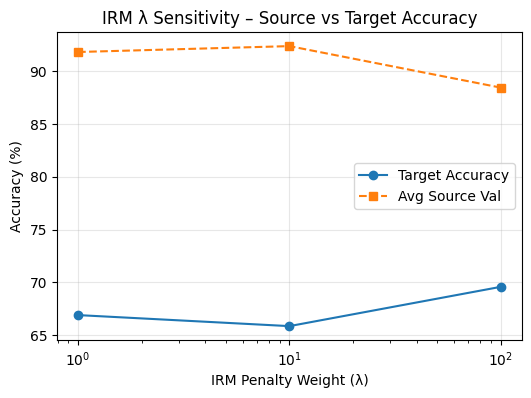

In [38]:
# After loading all histories
irm_lambda_results = consolidate_irm_lambda_histories(loaded_histories, results_dir=None)

# Plot using the existing function
plot_irm_lambda_sweep(irm_lambda_results)

In [30]:
summary_df = summarize_results(histories)
display(summary_df)
summary_df.to_csv(exp_path(".", "summary.csv"), index=False)
print(f"[Saved summary] {exp_path('root', 'summary.csv')}")

,Method,Best Val Avg,Target Acc,Generalization Gap
0,ERM,97.39%,67.19%,30.20%
1,IRM,92.32%,75.41%,16.91%
2,GroupDRO,94.65%,72.82%,21.83%
3,SAM,97.77%,70.55%,27.22%


[Saved summary] experiments/20251013_204845/root/summary.csv


In [31]:
# plt.figure(figsize=(8, 5))
# for name, h in histories.items():
#     plt.plot(h["val_avg"], label=f"{name} Val Avg")
# plt.title("Validation Accuracy Across Methods")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# save_fig(plt.gcf(), "val_accuracy_comparison.png")
# plt.show()

In [32]:
# for name, h in histories.items():
#     plot_per_domain_bars(h["val_per_domain"][-1], f"{name}: Per-Domain Validation Accuracy")

In [33]:
# if "train_penalty" in irm_history and irm_history["train_penalty"]:
#     plt.figure(figsize=(6,4))
#     plt.plot(irm_history["train_penalty"], label="IRM Penalty")
#     plt.title("IRM Penalty over Epochs (λ = 10)")
#     plt.xlabel("Epoch")
#     plt.ylabel("Penalty Value")
#     plt.legend()
#     save_fig(plt.gcf(), "irm_penalty_curve.png")
#     plt.show()

In [34]:
# if "q_history" in gdro_history and gdro_history["q_history"]:
#     q_arr = np.array(gdro_history["q_history"])
#     plt.figure(figsize=(8,4))
#     for i, d in enumerate(config.SOURCE_DOMAINS):
#         plt.plot(q_arr[:, i], label=d)
#     plt.title("GroupDRO Domain Weights (q) over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("q value")
#     plt.legend()
#     save_fig(plt.gcf(), "groupdro_q_evolution.png")
#     plt.show()

In [35]:
# methods = []
# gaps = []
# for name, h in histories.items():
#     if len(h["target_acc"]) == 0: continue
#     val_avg = max(h["val_avg"])
#     gap = val_avg - h["target_acc"][-1]
#     methods.append(name)
#     gaps.append(gap * 100)

# plt.figure(figsize=(6,4))
# sns.barplot(x=methods, y=gaps)
# plt.title("Generalization Gap (Val Avg - Target Acc)")
# plt.ylabel("Gap (%)")
# save_fig(plt.gcf(), "generalization_gap.png")
# plt.show()

In [36]:
# from math import pi

# methods = ["ERM", "IRM", "GroupDRO", "SAM"]
# metrics = ["Val Avg", "Target Acc", "1 - Gap"]

# data = []
# for name in methods:
#     h = histories[name]
#     val_avg = max(h["val_avg"])
#     target_acc = h["target_acc"][-1]
#     gap = val_avg - target_acc
#     data.append([val_avg, target_acc, 1 - gap])

# df = pd.DataFrame(data, columns=metrics, index=methods)

# # Radar chart
# angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
# angles += angles[:1]
# fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
# for i, (name, row) in enumerate(df.iterrows()):
#     values = row.tolist()
#     values += values[:1]
#     ax.plot(angles, values, label=name)
# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(metrics)
# plt.title("Trade-offs Between Methods")
# plt.legend(loc="upper right")
# save_fig(plt.gcf(), "radar_comparison.png")
# plt.show()

[t-SNE] Reducing 2048D features for ERM...
[Saved Figure] experiments/20251013_204845/figures/erm_tsne_combined.png
✅ Saved t-SNE figure to: erm_tsne_combined.png


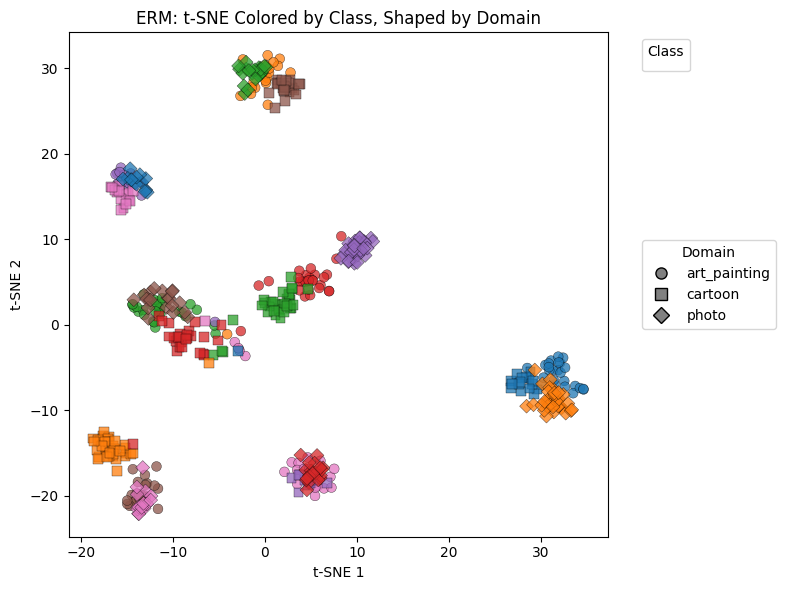

[t-SNE] Reducing 2048D features for IRM...
[Saved Figure] experiments/20251013_204845/figures/irm_tsne_combined.png
✅ Saved t-SNE figure to: irm_tsne_combined.png


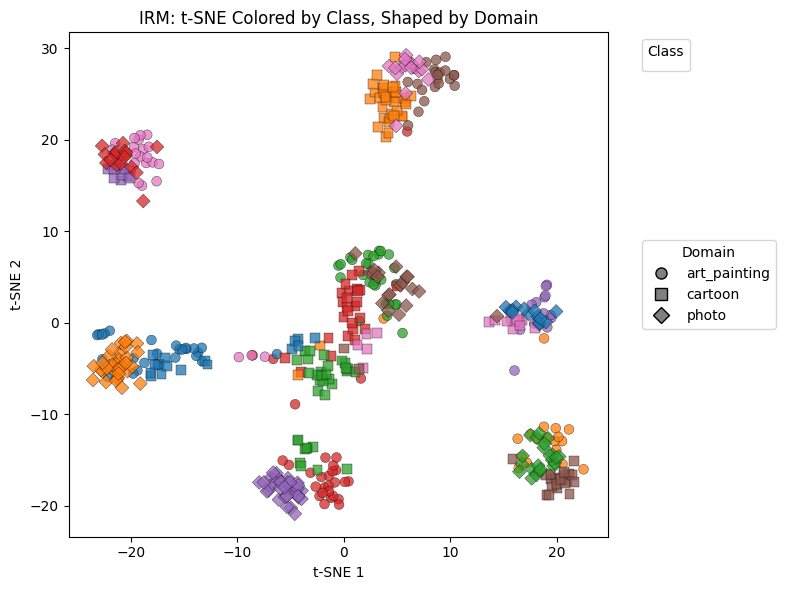

[t-SNE] Reducing 2048D features for GroupDRO...
[Saved Figure] experiments/20251013_204845/figures/groupdro_tsne_combined.png
✅ Saved t-SNE figure to: groupdro_tsne_combined.png


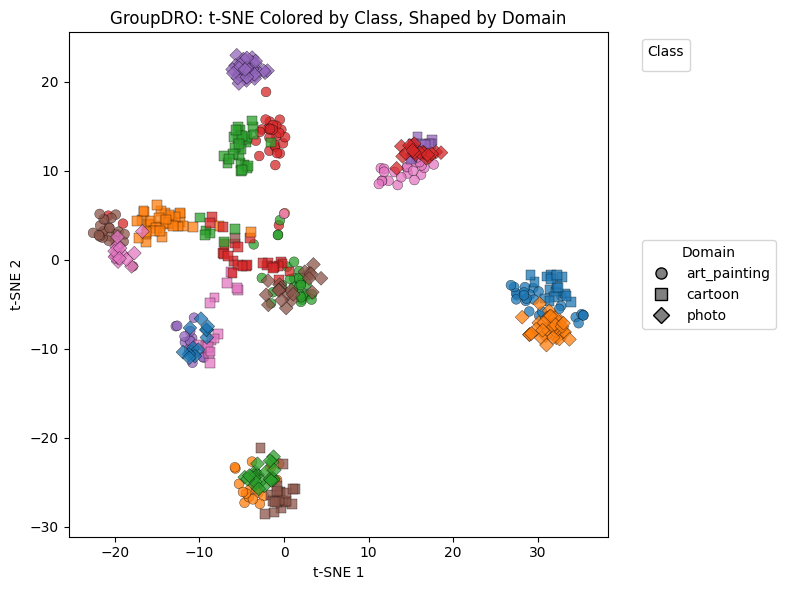

[t-SNE] Reducing 2048D features for SAM...
[Saved Figure] experiments/20251013_204845/figures/sam_tsne_combined.png
✅ Saved t-SNE figure to: sam_tsne_combined.png


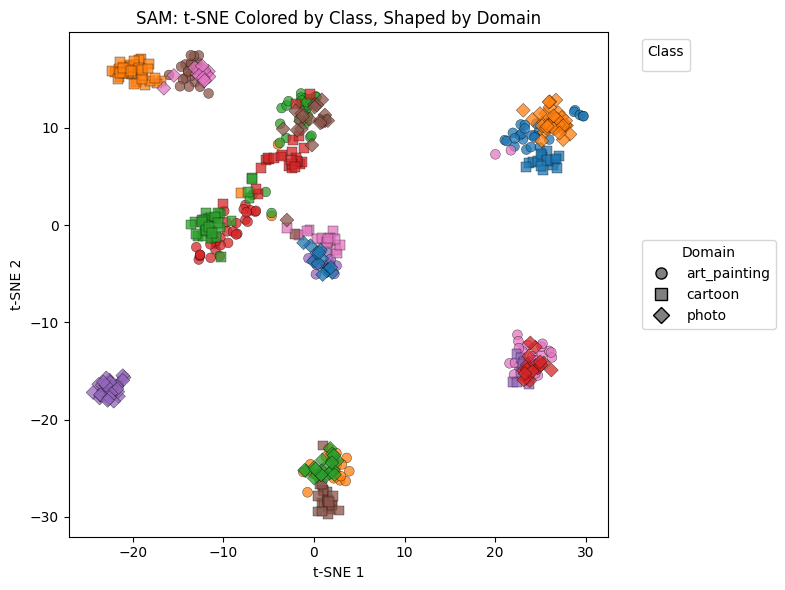

In [44]:
class_names = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]

for name, model in [
    ("ERM", loaded_models["erm_best"]),
    ("IRM", loaded_models["irm_best"]),
    ("GroupDRO", loaded_models["gdro_best"]),
    ("SAM", loaded_models["sam_best"])
]:
    feats, labels, domains = extract_features(model, source_val_loaders, max_batches=5)
    plot_tsne_both(feats, labels, domains, class_names, name)


[ERM] Base loss = 0.0170
ERM ΔLoss values: [ 0.00000000e+00  1.50000000e-04  1.08400000e-03 -7.28000000e-04
 -1.95100000e-03  2.05268500e+00  2.52141940e+01  7.60382800e+00
  2.45478136e+03  8.36195665e+15]

[SAM] Base loss = 0.0078
SAM ΔLoss values: [ 0.00000000e+00 -5.30000000e-05  2.33600000e-03  2.20000000e-04
  2.56000000e-03  1.60501900e+00  3.36671300e+00  1.49160910e+01
  9.62341824e+02  5.31439490e+14]
[Saved Figure] experiments/20251013_204845/figures/flatness_comparison.png


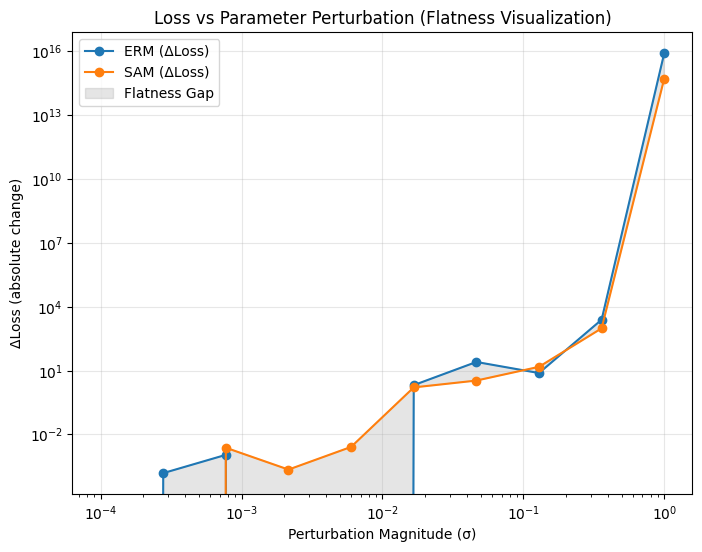

In [38]:
plot_loss_vs_perturbation(
    models={
        "ERM": loaded_models["erm_best"],
        "SAM": loaded_models["sam_best"]
    },
    dataloader=source_val_loaders["photo"],
    criterion=nn.CrossEntropyLoss(),
    device=config.DEVICE
)

torch.cuda.empty_cache()

[Saved Figure] experiments/20251013_204845/figures/loss_landscape_erm.png


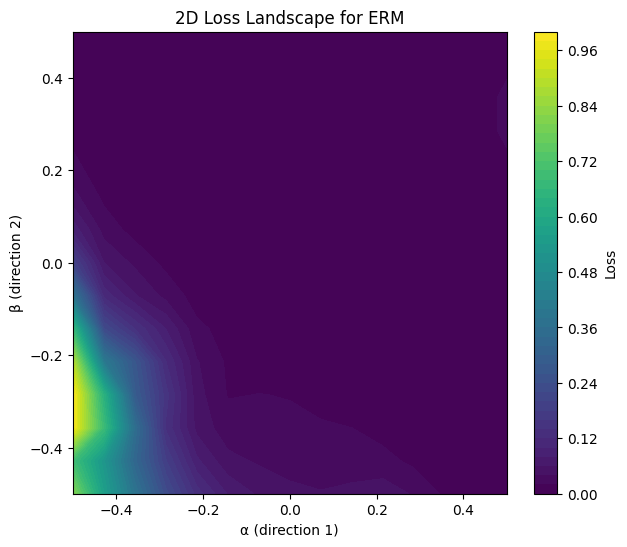

[Saved Figure] experiments/20251013_204845/figures/loss_landscape_sam.png


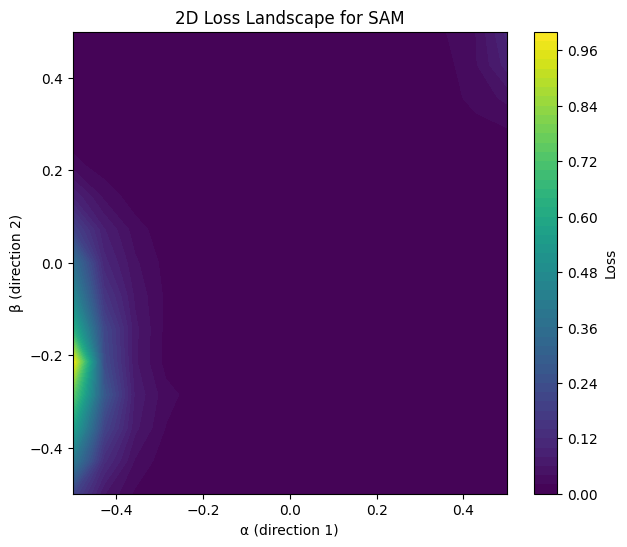

In [53]:
plot_loss_landscape_2d(
    model=loaded_models["erm_best"],
    dataloader=source_val_loaders["photo"],
    criterion=nn.CrossEntropyLoss(),
    device=config.DEVICE,
    name="ERM",
)

plot_loss_landscape_2d(
    model=loaded_models["sam_best"],
    dataloader=source_val_loaders["photo"],
    criterion=nn.CrossEntropyLoss(),
    device=config.DEVICE,
    name="SAM",
)


[ERM] Computing 2D loss landscape...

[SAM] Computing 2D loss landscape...
[Saved Figure] experiments/20251013_204845/figures/loss_landscape_2d_comparison.png


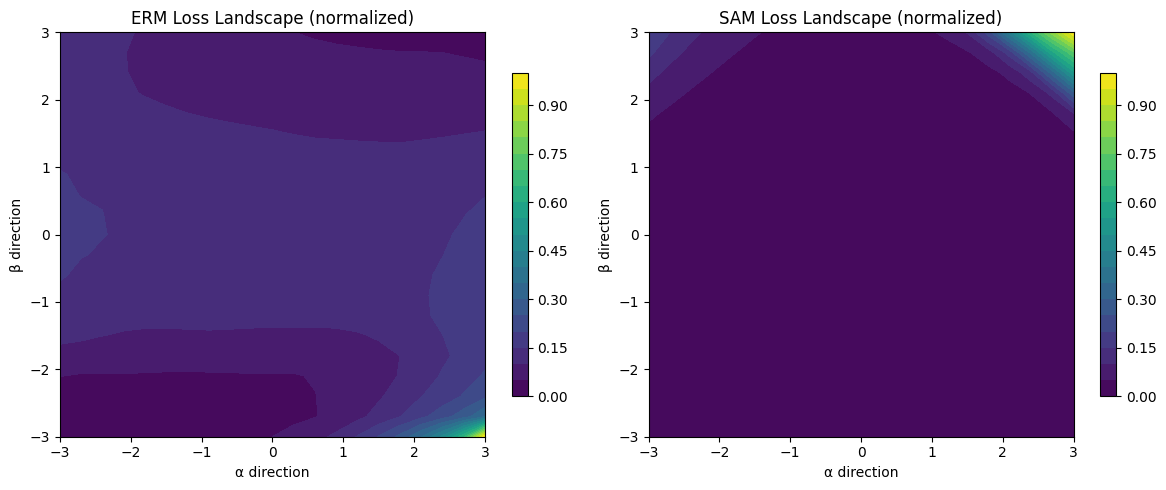

In [40]:
plot_loss_landscape_2d_compare(
    models={"ERM": loaded_models["erm_best"], "SAM": loaded_models["sam_best"]},
    dataloader=source_val_loaders["photo"],
    criterion=nn.CrossEntropyLoss(),
    device=config.DEVICE,
    grid_size=21,
    alpha=1e-3,
    range_limit=3.0,
)


[ERM] Computing 3D loss surface...

[SAM] Computing 3D loss surface...
[Saved Figure] experiments/20251013_204845/figures/loss_landscape_3d_comparison.png


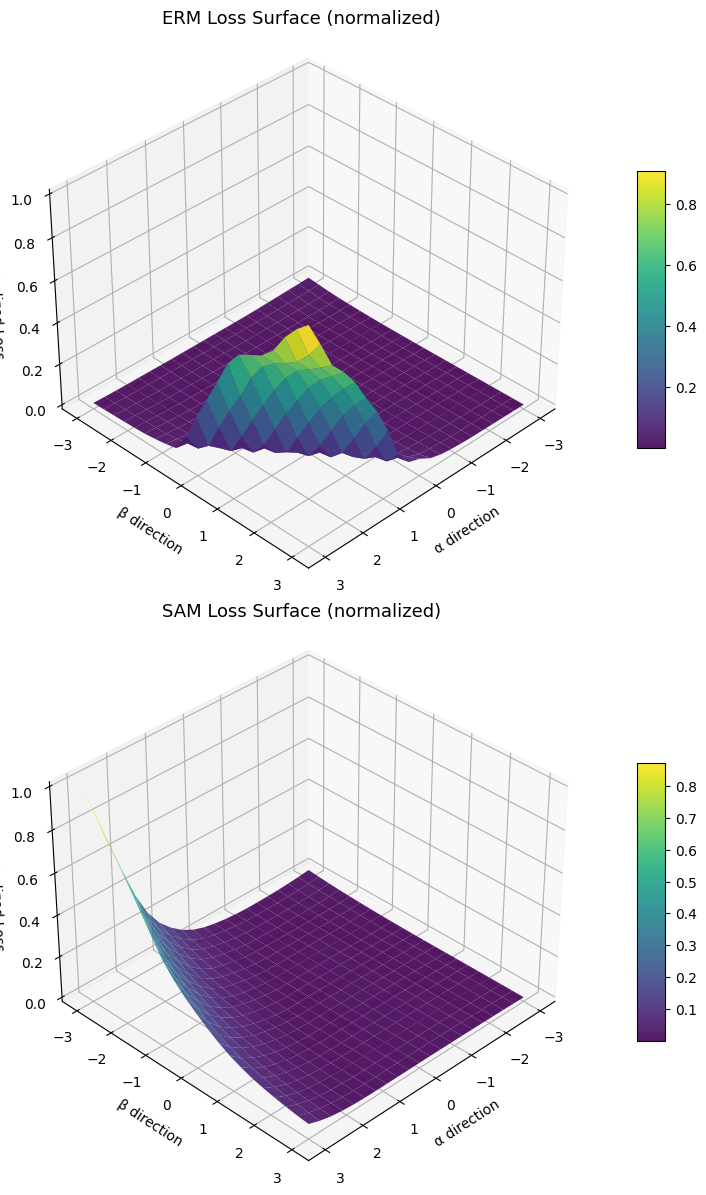

In [41]:
plot_loss_landscape_3d_compare(
    models={
        "ERM": loaded_models["erm_best"],
        "SAM": loaded_models["sam_best"]
    },
    dataloader=source_val_loaders["photo"],
    criterion=nn.CrossEntropyLoss(),
    device=config.DEVICE,
    grid_size=21,
    alpha=1e-3,
    range_limit=3.0
)

[Saved Figure] experiments/20251013_204845/figures/mean_rel_increase_per_domain.png


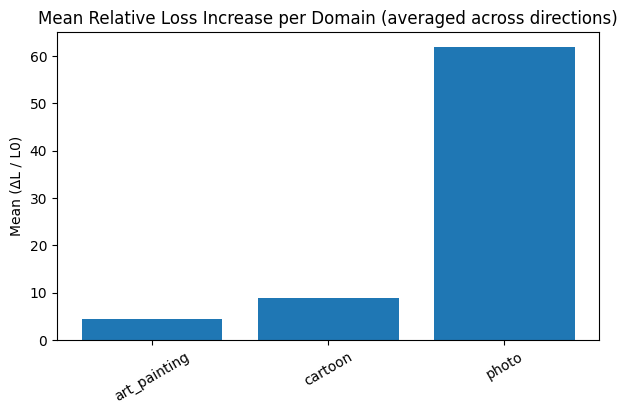

[Saved Figure] experiments/20251013_204845/figures/mean_rel_increase_per_domain.png


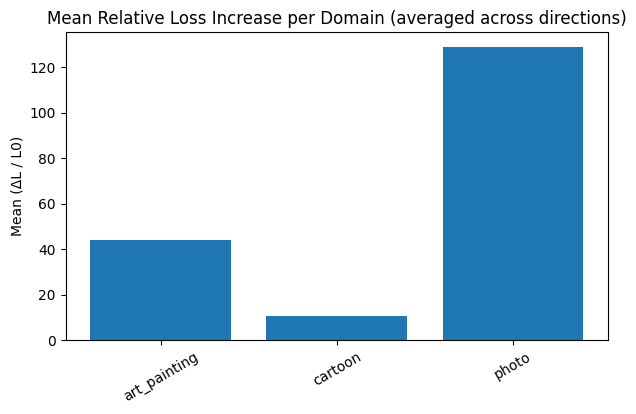

[Saved Figure] experiments/20251013_204845/figures/per_dir_std_distribution.png


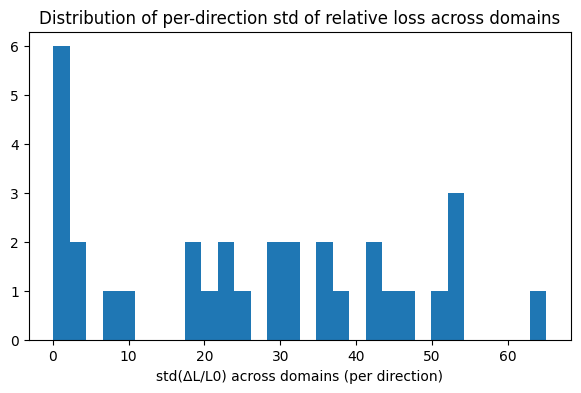

In [50]:
results_erm = compute_cross_domain_flatness(
    model=loaded_models["erm_best"],
    domain_loaders=source_val_loaders,   # dict of domain->loader
    criterion=nn.CrossEntropyLoss(),
    device=config.DEVICE,
    n_dirs=32,
    mag=0.01,
    max_batches=1,
    epsilon=0.03
)

# same for SAM
results_sam = compute_cross_domain_flatness(
    model=loaded_models["sam_best"],
    domain_loaders=source_val_loaders,
    criterion=nn.CrossEntropyLoss(),
    device=config.DEVICE,
    n_dirs=32, mag=0.01, max_batches=1, epsilon=0.03
)

plot_per_domain_rel_increase(results_erm)
plot_per_domain_rel_increase(results_sam)
plot_std_distribution(results_erm)


[Saved Figure] experiments/20251013_204845/figures/dir0_rel_losses.png


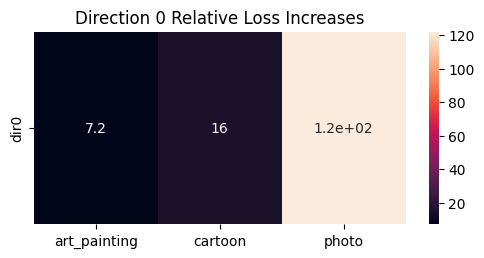

[Saved Figure] experiments/20251013_204845/figures/dir0_rel_losses.png


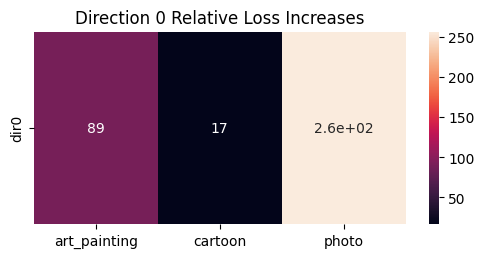

In [51]:
plot_per_direction_heatmap(results_erm)
plot_per_direction_heatmap(results_sam)

In [43]:
# summary_path = os.path.join(EXP_DIR, "summary.csv")
# summary_df.to_csv(summary_path, index=False)
# print(f"[Summary] Saved performance summary → {summary_path}")

In [54]:
!zip -r figures.zip ./experiments/20251013_204845/figures

  adding: experiments/20251013_204845/figures/ (stored 0%)
  adding: experiments/20251013_204845/figures/loss_landscape_sam.png (deflated 16%)
  adding: experiments/20251013_204845/figures/irm_tsne.png (deflated 3%)
  adding: experiments/20251013_204845/figures/irm_tsne_combined.png (deflated 7%)
  adding: experiments/20251013_204845/figures/generalization_gap.png (deflated 15%)
  adding: experiments/20251013_204845/figures/ERM: Per-Domain Validation Accuracy.png (deflated 18%)
  adding: experiments/20251013_204845/figures/groupdro_q_evolution.png (deflated 10%)
  adding: experiments/20251013_204845/figures/sam_tsne.png (deflated 3%)
  adding: experiments/20251013_204845/figures/mean_rel_increase_per_domain.png (deflated 20%)
  adding: experiments/20251013_204845/figures/radar_comparison.png (deflated 4%)
  adding: experiments/20251013_204845/figures/loss_vs_perturbation (ERM-SAM).png (deflated 21%)
  adding: experiments/20251013_204845/figures/SAM: Per-Domain Validation Accuracy.png (

In [39]:
histories

{'ERM': {'train_loss': [0.5533265274937655,
   0.07226951635880774,
   0.0436624432922602,
   0.023546695058512722,
   0.014969631425873486],
  'train_acc': [0.8562590224788617,
   0.9799958754382347,
   0.9880387708805939,
   0.9958754382346876,
   0.9962878944112188],
  'train_erm': [],
  'train_penalty': [],
  'val_avg': [0.9535138989274038,
   0.967855572852423,
   0.9739453331103668,
   0.9693109490624036,
   0.967324636181898],
  'val_per_domain': [{'art_painting': 0.9390243902439024,
    'cartoon': 0.9275053304904051,
    'photo': 0.9940119760479041},
   {'art_painting': 0.9658536585365853,
    'cartoon': 0.9466950959488273,
    'photo': 0.9910179640718563},
   {'art_painting': 0.9585365853658536,
    'cartoon': 0.9722814498933902,
    'photo': 0.9910179640718563},
   {'art_painting': 0.9634146341463414,
    'cartoon': 0.9594882729211087,
    'photo': 0.9850299401197605},
   {'art_painting': 0.9463414634146341,
    'cartoon': 0.9616204690831557,
    'photo': 0.9940119760479041}]

In [40]:
def summarize_histories(histories):
    rows = []

    for method, hist in histories.items():
        if method == "IRM_LAMBDAS":
            continue  # handle separately

        val_avg = hist["val_avg"][-1] if hist["val_avg"] else None
        target = hist["target_acc"][-1] if hist["target_acc"] else None
        train_acc = hist["train_acc"][-1] if hist["train_acc"] else None

        val_std = np.std(hist["val_avg"]) if hist["val_avg"] else None

        rows.append({
            "Method": method,
            "Final Train Acc": train_acc * 100 if train_acc else None,
            "Final Val Avg": val_avg * 100 if val_avg else None,
            "Val Std (stability)": val_std * 100 if val_std else None,
            "Target Acc": target * 100 if target else None,
        })

    df_main = pd.DataFrame(rows)
    print("\n===== Main Methods Summary =====")
    print(df_main.to_string(index=False, float_format="%.2f"))

    # IRM λ Sweep summary
    irm_rows = []
    irm_histories = histories.get("IRM_LAMBDAS", {})
    for name, hist in irm_histories.items():
        lam = int(name.split("irm_lambda")[1].split("_")[0])
        val_avg = hist["val_avg"][-1] if hist["val_avg"] else None
        target = hist["target_acc"][-1] if hist["target_acc"] else None
        train_acc = hist["train_acc"][-1] if hist["train_acc"] else None
        irm_rows.append({
            "λ": lam,
            "Train Acc": train_acc * 100 if train_acc else None,
            "Val Avg": val_avg * 100 if val_avg else None,
            "Target Acc": target * 100 if target else None,
        })
    df_irm = pd.DataFrame(irm_rows).sort_values("λ")
    print("\n===== IRM λ-Sweep Summary =====")
    print(df_irm.to_string(index=False, float_format="%.2f"))

    return df_main, df_irm

df_main, df_irm = summarize_histories(histories)


===== Main Methods Summary =====
  Method  Final Train Acc  Final Val Avg  Val Std (stability)  Target Acc
     ERM            99.63          96.73                 0.68       67.19
     IRM            94.93          88.43                 6.29       69.59
GroupDRO            99.58          94.65                 2.43       72.82
     SAM            99.88          97.77                 0.51       70.55

===== IRM λ-Sweep Summary =====
  λ  Train Acc  Val Avg  Target Acc
  1      99.32    91.80       66.91
 10      98.89    92.35       65.87
100      94.93    88.43       69.59


[Saved Figure] experiments/20251013_204845/figures/training_loss_comparison.png


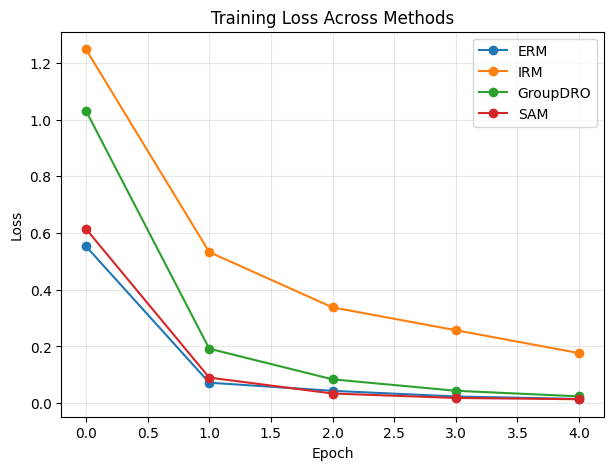

[Saved Figure] experiments/20251013_204845/figures/training_accuracy_comparison.png


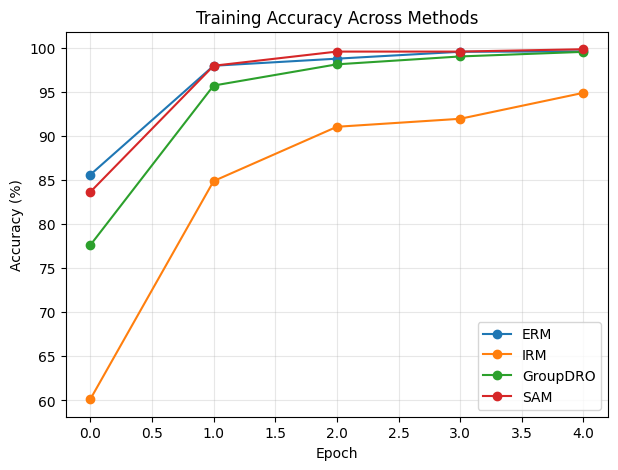

[Saved Figure] experiments/20251013_204845/figures/validation_accuracy_comparison.png


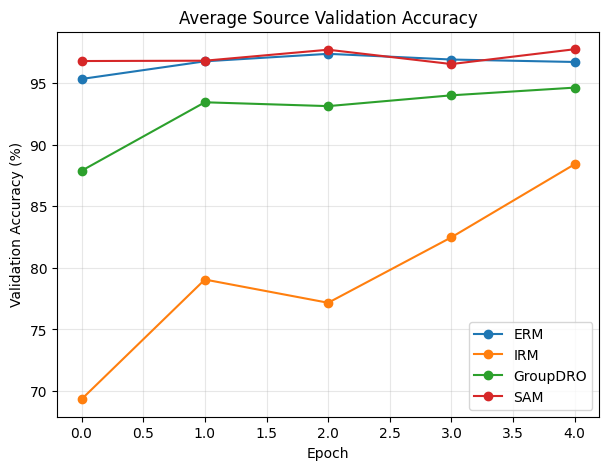

[Saved Figure] experiments/20251013_204845/figures/target_accuracy_comparison.png


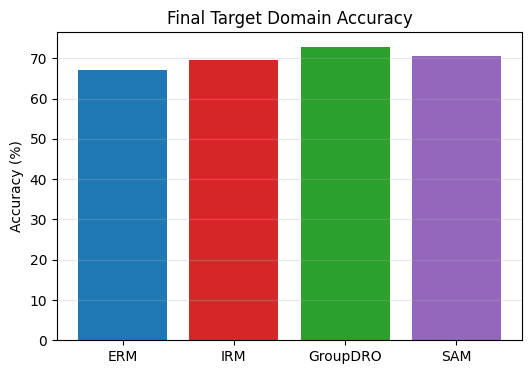

[Saved Figure] experiments/20251013_204845/figures/irm_lambda_sweep_accuracy.png


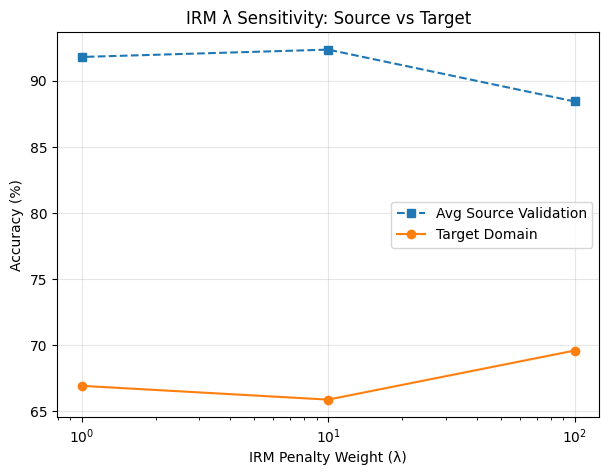

[Saved Figure] experiments/20251013_204845/figures/irm_lambda_penalty.png


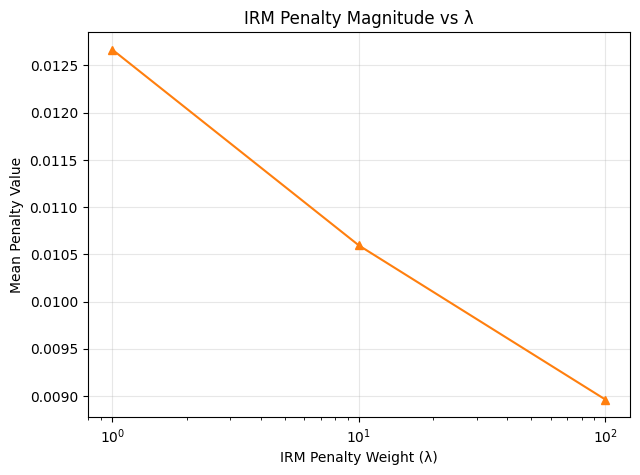


✅ All training, validation, and λ-sweep visualizations complete.


In [41]:
def plot_training_histories(histories, save=True):
    """
    Visualize training and validation trends for all DG methods + IRM λ sweep.
    Uses loaded `histories` dictionary.
    """

    # 1️⃣ Main methods
    main_methods = [k for k in histories.keys() if k not in ["IRM_LAMBDAS"]]
    colors = {
        "ERM": "#1f77b4",       # blue
        "IRM": "#d62728",       # red
        "GroupDRO": "#2ca02c",  # green
        "SAM": "#9467bd",       # purple
    }

    # ---- Training Loss ----
    plt.figure(figsize=(7, 5))
    for m in main_methods:
        if histories[m]["train_loss"]:
            plt.plot(histories[m]["train_loss"], marker="o", label=f"{m}")
    plt.title("Training Loss Across Methods")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    if save:
        save_fig(plt.gcf(), "training_loss_comparison.png")
    plt.show()

    # ---- Training Accuracy ----
    plt.figure(figsize=(7, 5))
    for m in main_methods:
        if histories[m]["train_acc"]:
            plt.plot(np.array(histories[m]["train_acc"]) * 100, marker="o", label=f"{m}")
    plt.title("Training Accuracy Across Methods")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(alpha=0.3)
    if save:
        save_fig(plt.gcf(), "training_accuracy_comparison.png")
    plt.show()

    # ---- Validation Accuracy ----
    plt.figure(figsize=(7, 5))
    for m in main_methods:
        if histories[m]["val_avg"]:
            plt.plot(np.array(histories[m]["val_avg"]) * 100, marker="o", label=f"{m}")
    plt.title("Average Source Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.legend()
    plt.grid(alpha=0.3)
    if save:
        save_fig(plt.gcf(), "validation_accuracy_comparison.png")
    plt.show()

    # ---- Target Accuracy (Bar Plot) ----
    plt.figure(figsize=(6, 4))
    target_accs = [histories[m]["target_acc"][0] * 100 for m in main_methods if histories[m]["target_acc"]]
    plt.bar(main_methods, target_accs, color=[colors[m] for m in main_methods])
    plt.title("Final Target Domain Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y", alpha=0.3)
    if save:
        save_fig(plt.gcf(), "target_accuracy_comparison.png")
    plt.show()

    # 2️⃣ IRM λ-Sweep
    if "IRM_LAMBDAS" in histories:
        irm_histories = histories["IRM_LAMBDAS"]
        lambdas = []
        val_accs = []
        target_accs = []
        penalties = []

        for name, hist in irm_histories.items():
            lam = int(name.split("irm_lambda")[1].split("_")[0])
            lambdas.append(lam)
            val_accs.append(hist["val_avg"][-1] * 100)
            target_accs.append(hist["target_acc"][-1] * 100)
            penalties.append(np.nanmean([p for p in hist["train_penalty"] if p is not None]))

        plt.figure(figsize=(7, 5))
        plt.plot(lambdas, val_accs, marker="s", linestyle="--", label="Avg Source Validation")
        plt.plot(lambdas, target_accs, marker="o", label="Target Domain")
        plt.xscale("log")
        plt.xlabel("IRM Penalty Weight (λ)")
        plt.ylabel("Accuracy (%)")
        plt.title("IRM λ Sensitivity: Source vs Target")
        plt.legend()
        plt.grid(alpha=0.3)
        if save:
            save_fig(plt.gcf(), "irm_lambda_sweep_accuracy.png")
        plt.show()

        # Optional: visualize penalty evolution
        plt.figure(figsize=(7, 5))
        plt.plot(lambdas, penalties, marker="^", color="#ff7f0e")
        plt.xscale("log")
        plt.xlabel("IRM Penalty Weight (λ)")
        plt.ylabel("Mean Penalty Value")
        plt.title("IRM Penalty Magnitude vs λ")
        plt.grid(alpha=0.3)
        if save:
            save_fig(plt.gcf(), "irm_lambda_penalty.png")
        plt.show()

    print("\n✅ All training, validation, and λ-sweep visualizations complete.")

# Run it
plot_training_histories(histories)


In [42]:
def analyze_method_specific_metrics(histories):
    """
    Parse the loaded `histories` dict and extract method-specific
    diagnostic metrics like IRM penalties, GroupDRO weights, etc.
    Returns both printed summary and a Pandas DataFrame.
    """
    records = []

    print("=" * 80)
    print("📈 METHOD-SPECIFIC METRIC ANALYSIS")
    print("=" * 80)

    for method, hist in histories.items():
        if method == "IRM_LAMBDAS":
            continue  # handled separately below

        # --- General metrics ---
        target_acc = hist["target_acc"][-1] * 100 if hist["target_acc"] else np.nan
        val_acc = hist["val_avg"][-1] * 100 if hist["val_avg"] else np.nan
        final_train_loss = hist["train_loss"][-1] if hist["train_loss"] else np.nan
        final_train_acc = hist["train_acc"][-1] * 100 if hist["train_acc"] else np.nan

        record = {
            "Method": method,
            "Final Train Loss": round(final_train_loss, 4),
            "Final Train Acc (%)": round(final_train_acc, 2),
            "Final Val Acc (%)": round(val_acc, 2),
            "Target Acc (%)": round(target_acc, 2),
        }

        # --- Method-specific details ---
        if method == "IRM":
            penalties = [p for p in hist["train_penalty"] if p is not None]
            avg_penalty = np.mean(penalties) if penalties else np.nan
            std_penalty = np.std(penalties) if penalties else np.nan
            record.update({
                "IRM λ": getattr(hist, "irm_penalty_weight", "10 (default)"),
                "IRM Penalty (mean)": round(avg_penalty, 6),
                "IRM Penalty (std)": round(std_penalty, 6)
            })
            print(f"[IRM] λ={record['IRM λ']}, mean penalty={avg_penalty:.6f}, std={std_penalty:.6f}")

        elif method == "GroupDRO":
            if hist["q_history"]:
                q_array = np.array(hist["q_history"])
                avg_q = np.mean(q_array, axis=0)
                std_q = np.std(q_array, axis=0)
                record.update({
                    "Avg Domain Weights (q)": np.round(avg_q, 4).tolist(),
                    "Std Domain Weights (q)": np.round(std_q, 4).tolist()
                })
                print(f"[GroupDRO] avg domain weights={avg_q}, std={std_q}")
            else:
                record["Avg Domain Weights (q)"] = "-"
                record["Std Domain Weights (q)"] = "-"

        elif method == "SAM":
            # you could optionally compute flatness proxy via loss range
            loss_range = np.ptp(hist["train_loss"]) if hist["train_loss"] else np.nan
            record.update({"Flatness Proxy (ΔLoss)": round(loss_range, 4)})
            print(f"[SAM] Flatness proxy ΔLoss={loss_range:.6f}")

        elif method == "ERM":
            print(f"[ERM] Baseline target={target_acc:.2f}%, validation={val_acc:.2f}%")

        records.append(record)

    # Convert to DataFrame for display
    df = pd.DataFrame(records).set_index("Method")
    print("\nSummary Table:")
    display(df)

    # --- IRM λ-sweep summary ---
    if "IRM_LAMBDAS" in histories:
        print("\n" + "=" * 80)
        print("📊 IRM λ-SWEEP SUMMARY")
        print("=" * 80)
        lambda_records = []
        for name, hist in histories["IRM_LAMBDAS"].items():
            lam = int(name.split("irm_lambda")[1].split("_")[0])
            val_acc = hist["val_avg"][-1] * 100
            target_acc = hist["target_acc"][-1] * 100
            penalties = [p for p in hist["train_penalty"] if p is not None]
            avg_penalty = np.mean(penalties) if penalties else np.nan
            lambda_records.append({
                "λ": lam,
                "Avg Val (%)": round(val_acc, 2),
                "Target (%)": round(target_acc, 2),
                "Mean Penalty": round(avg_penalty, 6)
            })
            print(f"λ={lam:>4} | Val={val_acc:6.2f}% | Target={target_acc:6.2f}% | Penalty={avg_penalty:.6f}")

        df_lambda = pd.DataFrame(lambda_records).sort_values("λ")
        display(df_lambda)

    return df

# Run analysis
metrics_df = analyze_method_specific_metrics(histories)

📈 METHOD-SPECIFIC METRIC ANALYSIS
[ERM] Baseline target=67.19%, validation=96.73%
[IRM] λ=10 (default), mean penalty=0.008961, std=0.004257
[GroupDRO] avg domain weights=[0.38284516 0.51044981 0.10670502], std=[0.01536983 0.04385728 0.02990592]
[SAM] Flatness proxy ΔLoss=0.600833

Summary Table:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Final Train Loss,Final Train Acc (%),Final Val Acc (%),Target Acc (%),IRM λ,IRM Penalty (mean),IRM Penalty (std),Avg Domain Weights (q),Std Domain Weights (q),Flatness Proxy (ΔLoss)
Method,,,,,,,,,,
ERM,0.0150,99.63,96.73,67.19,NaN,NaN,NaN,NaN,NaN,NaN
IRM,0.1765,94.93,88.43,69.59,10 (default),0.008961,0.004257,NaN,NaN,NaN
GroupDRO,0.0241,99.58,94.65,72.82,NaN,NaN,NaN,"[0.3828, 0.5104, 0.1067]","[0.0154, 0.0439, 0.0299]",NaN
SAM,0.0140,99.88,97.77,70.55,NaN,NaN,NaN,NaN,NaN,0.6008



📊 IRM λ-SWEEP SUMMARY
λ= 100 | Val= 88.43% | Target= 69.59% | Penalty=0.008961
λ=  10 | Val= 92.35% | Target= 65.87% | Penalty=0.010594
λ=   1 | Val= 91.80% | Target= 66.91% | Penalty=0.012668


,λ,Avg Val (%),Target (%),Mean Penalty
2,1,91.80,66.91,0.012668
1,10,92.35,65.87,0.010594
0,100,88.43,69.59,0.008961


In [43]:
!zip -r experiment_2.zip ./experiments

  adding: experiments/ (stored 0%)
  adding: experiments/20251013_204845/ (stored 0%)
  adding: experiments/20251013_204845/histories/ (stored 0%)
  adding: experiments/20251013_204845/histories/final_sam_history.pkl (deflated 22%)
  adding: experiments/20251013_204845/histories/irm_lambda10_history.pkl (deflated 18%)
  adding: experiments/20251013_204845/histories/final_irm_history.pkl (deflated 18%)
  adding: experiments/20251013_204845/histories/irm_lambda1_history.pkl (deflated 21%)
  adding: experiments/20251013_204845/histories/irm_lambda100_history.pkl (deflated 18%)
  adding: experiments/20251013_204845/histories/final_gdro_history.pkl (deflated 26%)
  adding: experiments/20251013_204845/histories/final_erm_history.pkl (deflated 22%)
  adding: experiments/20251013_204845/summary.csv (deflated 11%)
  adding: experiments/20251013_204845/figures/ (stored 0%)
  adding: experiments/20251013_204845/figures/GroupDRO: Per-Domain Validation Accuracy.png (deflated 17%)
  adding: experime